[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Unscented Kalman Filters

In [1]:
#format the book
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function
import book_format
book_format.load_style()

In the last chapter we discussed the difficulties that nonlinear systems pose. This nonlinearity can appear in two places. It can be in our measurements, such as a radar that is measuring the slant range to an object. Slant range requires you to take a square root to compute the x,y coordinates:

$$x=\sqrt{slant^2 - altitude^2}$$

The nonlinearity can also occur in the process model - we may be tracking a ball traveling through the air, where the effects of gravity and air drag lead to highly nonlinear behavior. The standard Kalman filter performs poorly or not at all with these sorts of problems.

In the last chapter I showed you a plot like this. I have altered the equation somewhat to emphasize the effects of nonlinearity.

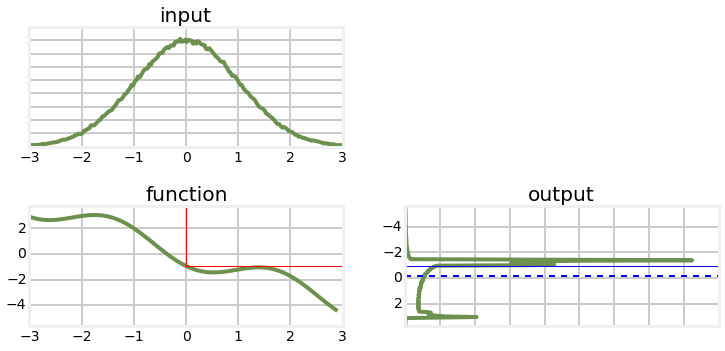

In [2]:
from numpy.random import normal
import numpy as np
import matplotlib.pyplot as plt
from nonlinear_plots import plot_transfer_func

gaussian=(0., 1.)
data = normal(loc=gaussian[0], scale=gaussian[1], size=500000)

def g(x):
    return (np.cos(4*(x/2 + 0.7))) - 1.3*x

with book_format.figsize(y=5):
    plot_transfer_func(data, g, gaussian=gaussian)

I generated this by taking 500,000 samples from the input, passing it through the nonlinear transform, and building a histogram of the result. We call these points **sigma points**. From the output histogram we can compute a mean and standard deviation which would give us an updated, albeit approximated Gaussian.

It has perhaps occurred to you that this sampling process constitutes a solution to our problem. Suppose for every update we generated 500,000 points, passed them through the function, and then computed the mean and variance of the result. This is called a 'Monte Carlo' approach, and it used by some Kalman filter designs, such as the **Ensemble filter** and **particle filter**. Sampling requires no specialized knowledge, and does not require a closed form solution. No matter how nonlinear or poorly behaved the function is, as long as we sample with enough sigma points we will build an accurate output distribution.

"Enough points" is the rub. The graph above was created with 500,000 sigma points, and the output is still not smooth. What's worse, this is only for 1 dimension. In general, the number of points required increases by the power of the number of dimensions. If you only needed 500 points for 1 dimension, you'd need 500 squared, or 250,000 points for two dimensions, 500 cubed, or 125,000,000 points for three dimensions, and so on. So while this approach does work, it is very computationally expensive. The Unscented Kalman filter uses a similar technique but reduces the amount of computation needed by a drastic amount by using a deterministic method of choosing the points.

## Sigma Points - Sampling from the Distribution

Let's look at the problem in terms of a 2D covariance ellipse. I choose 2D merely because it is easy to plot; this will extend to any number of dimensions. Assuming some arbitrary nonlinear function, we will take random points from the first covariance ellipse, pass them through the nonlinear function, and plot their new position. Then we can compute the the mean and covariance of the transformed points, and use that as our estimate of the mean and probability distribution.

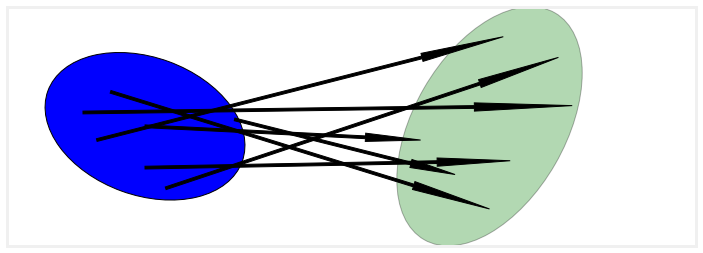

In [3]:
import ukf_internal
ukf_internal.show_2d_transform()

On the left we show an ellipse depicting the $1\sigma$ distribution of two state variables. The arrows show how several randomly sampled points might be transformed by some arbitrary nonlinear function to a new distribution. The ellipse on the right is drawn semi-transparently to indicate that it is an *estimate* of the mean and variance of this collection of points - if we were to sample, say, a million points the shape of the points might be very far different than an ellipse. 

Let's look at that by running a bunch of points through a nonlinear function. We will write a function to pass randomly generated points with a Gaussian distribution through the system

$$\begin{aligned}x&=x+y\\
y &= 0.1x^2 + y^2\end{aligned}$$ 

for the mean and covariance 

$$\mu = \begin{bmatrix}0\\0\end{bmatrix}, 
\Sigma=\begin{bmatrix}32&15\\15&40\end{bmatrix}$$

Difference in mean x=0.076, y=43.395


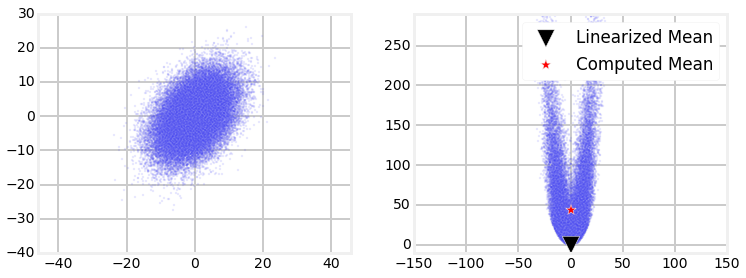

In [4]:
from numpy.random import randn, multivariate_normal
import numpy as np
from numpy import sin, cos, tan, log
import matplotlib.pyplot as plt

def f(x,y):
    return x+y, .1*x**2 + y*y


def monte_carlo_mean(xs, ys, f, mean_fx, label):  
    fxs, fys = [], []
    for x,y in zip(xs,ys):
        fx, fy = f(x,y)
        fxs.append(fx)
        fys.append(fy)

    computed_mean_x = np.average(fxs)
    computed_mean_y = np.average(fys)

    plt.subplot(121)
    plt.scatter(xs, ys, marker='.', alpha=0.1)
    plt.axis('equal')

    plt.subplot(122)
    plt.scatter(fxs, fys, marker='.', alpha=0.1)
    plt.scatter(mean_fx[0], mean_fx[1], 
                marker='v', s=300,c='k', label='Linearized Mean')
    plt.scatter(computed_mean_x, computed_mean_y, 
                marker='*',s=120,c='r', label='Computed Mean')
    plt.ylim([-10, 290])
    plt.xlim([-150, 150])
    plt.legend(loc='best', scatterpoints=1)
    print ('Difference in mean x={:.3f}, y={:.3f}'.format(
           computed_mean_x-mean_fx[0], computed_mean_y-mean_fx[1]))
   
mean = (0, 0)
p = np.array([[32, 15], [15., 40.]])

# Compute linearized mean
mean_fx = f(*mean)

#generate random points
xs, ys = multivariate_normal(mean=mean, cov=p, size=50000).T

monte_carlo_mean(xs, ys, f, mean_fx, 'Linearized Mean')
plt.show()

This plot shows the strong nonlinearity that occurs with this function, and the large error that would result if we linearized the function at (0,0), which is what filters like the Extended Kalman filters do (we will be learning this in the next chapter).

## Choosing Sigma Points

I used 50,000 randomly selected sigma points to generate this solution. While the computed mean is quite accurate, computing 50,000 points for every update would cause our filter to be very slow. So, what would be fewest number of sampled points that we can use, and what kinds of constraints does this problem formulation put on the points? We will assume that we have no special knowledge about the nonlinear function as we want to find a generalized algorithm that works for any function.
We can visualize this algorithm using the following diagram.

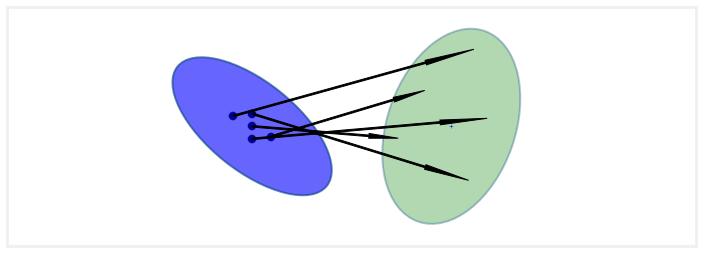

In [5]:
ukf_internal.show_sigma_transform()

Let's consider the simplest possible case and see if it offers any insight. The simplest possible system is the *identity function*. In mathematical notation this is $f(x) = x$. It should be clear that if our algorithm does not work for the identity function then the filter will never converge. In other words, if the input is  1 (for a one dimensional system), the output must also be 1. If the output was different, such as 1.1, then when we fed 1.1 into the transform at the next time step, we'd get out yet another number, maybe 1.23. The filter would run away (diverge). 

The fewest number of points that we can use is one per dimension. This is the number that the linear Kalman filter uses. The input to a Kalman filter for the distribution $\mathcal{N}(\mu,\sigma^2)$ is just $\mu$ itself. So while this works for the linear case, it is not a good answer for the nonlinear case.

Perhaps we can use one point per dimension, but altered somehow. However, if we were to pass some value $\mu+\Delta$ into the identity function $f(x)=x$ it would not converge, so this is not a possible algorithm. We must conclude that a one point sample will not work.

So, what is the next lowest number we can choose? Consider the fact that Gaussians are symmetric, and that we probably want to always have one of our sample points be the mean of the input for the identity function to work. Two points would require us to select the mean, and then one other point. That one other point would introduce an asymmetry in our input that we probably don't want. It would be very difficult to make this work for the identity function $f(x)=x$.

The next lowest number is 3 points. 3 points allows us to select the mean, and then one point on each side of the mean, as depicted on the chart below.

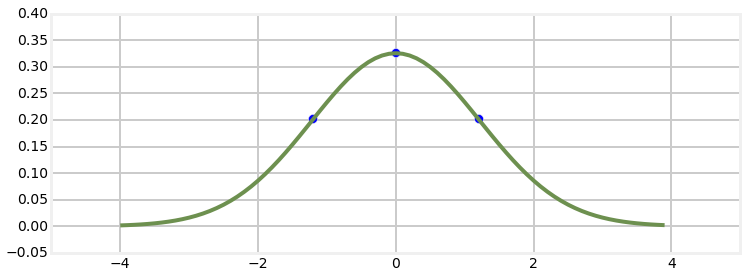

In [6]:
ukf_internal.show_3_sigma_points()

So we can take those three points, pass them through a nonlinear function f(x), and compute a new mean and variance. We can compute the mean as the average of the 3 points, but that is not very general. For example, for a very nonlinear problem we might want to weight the center point much higher than the outside points, or we might want to weight the outside points higher if the distribution is not Gaussian. A more general approach is to compute the mean as $\mu = \sum_i w_if(\mathcal{X}_i)$.


For this to work for identity we will want the sums of the weights for the mean to equal one. We can always come up with counterexamples, but in general if the sum is greater or less than one the sampling will not yield the correct output. Given that, we then have to select *sigma points* $\mathcal{X}$ and their corresponding weights so that they compute to the mean and variance of the input Gaussian. It is possible to use different weights for the mean ($w^m$) and for the variance ($w^c$). So we can write

$$\begin{aligned}
\mathbf{Constraints:}\\
\sum_i{w_i^m}&=1 \\
\mu &= \sum_i w_i^mf(\mathcal{X}_i) \\
\Sigma &= \sum_i w_i^c{(f(\mathcal{X})_i-\mu)(f(\mathcal{X})_i-\mu)^\mathsf{T}}
\end{aligned}
$$

If we look at this is should be clear that there is no one unique answer - the problem is unconstrained. For example, if you choose a smaller weight for the point at the mean for the input, you could compensate by choosing larger weights for the rest of the $\mathcal{X}$, and vice versa. We can use different weights for the mean and variances, or the same weights. Indeed, these equations do not require that any of the points be the mean of the input at all, though it seems 'nice' to do so, so to speak.

But before we go on I want to make sure the idea is clear. We are choosing 3 points for each dimension in our covariances. That choice is *entirely deterministic*. Below are three different examples for the same covariance ellipse.

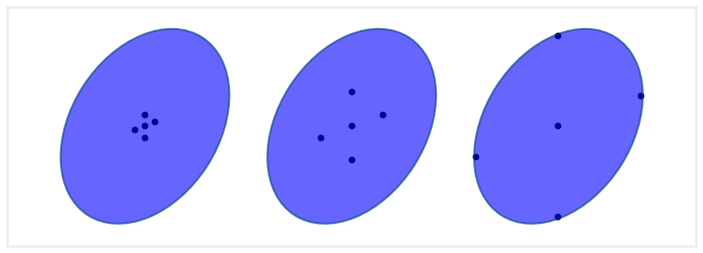

In [7]:
ukf_internal.show_sigma_selections()

The points do not lie along the major and minor axis of the ellipse; nothing in the constraints above require me to do that. Furthermore, in each case I show the points evenly spaced; again, the constraints above do not require that. 

We can see that the arrangement and spacing of the sigma points will affect how we sample our distribution. Points that are close together will sample local effects, and thus probably work better for very nonlinear problems. Points that are far apart, or far off the axis of the ellipse will sample non-local effects and non Gaussian behavior. However, by varying the weights used for each point we can mitigate this. If the points are far from the mean but weighted very slightly we will incorporate some of the knowledge about the distribution without allowing the nonlinearity of the problem to create a bad estimate. 

## Van der Merwe's Scaled Sigma Point Algorithm
There are several published ways for selecting the sigma points for the Unscented Kalman filter, and you are free to invent your own.  However, since 2005 or so research and industry have mostly settled on the version published by Rudolph Van der Merwe in his 2004 PhD dissertation [1] because it performs well with a variety of problems and it has a good tradeoff between performance and accuracy. It is a slight reformulation of the *Scaled Unscented Transform* published by Simon J. Julier [2].

Before we work through the derivation, let's just look at an example. I will plot the sigma points on top of a covariance ellipse showing the first and second standard deviations, and size them based on the weights assigned to them.

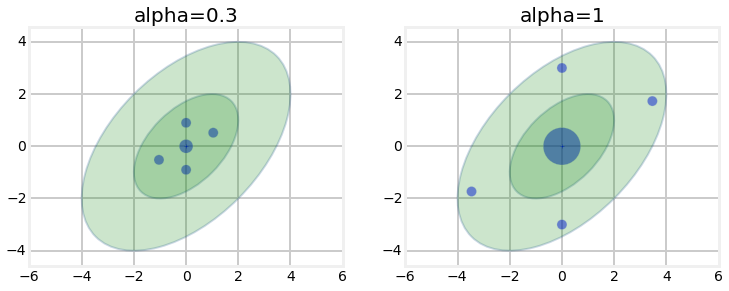

3.91


In [8]:
ukf_internal.plot_sigma_points()

We can see that the sigma points lie between the first and second deviation, and that the larger $\alpha$ spreads the points out further. Furthermore, the larger $\alpha$ weighs the mean (center point) higher than the smaller $\alpha$, and weighs the rest of the sigma points less. This should fit our intuition - the further a point is from the mean the less we should weight it. We don't know *how* these weights and sigma points are selected yet, but the choices look reasonable.

Van der Merwe's formulation uses 3 parameters to control how the sigma points are distributed and weighted: $\alpha$, $\beta$, and $\kappa$. We will go into detail with these later. For now, $\beta=2$ is a good choice for Gaussian problems, $\kappa=3-N$ is a good choice for $\kappa$, and $0 \le \alpha \le 1$ is an appropriate choice for $\alpha$, where a larger value spreads the sigma points further from the mean.

Our first sigma point is always going to be the mean of our input. This is the sigma point displayed in the center of the ellipses in the diagram above. We will call this $\boldsymbol{\chi}_0$. So,

$$ \mathcal{X}_0 = \mu$$

For notational convenience we define $\lambda = \alpha^2(n+\kappa)-n$. Then the remaining sigma points are computed as

$$ 
\begin{aligned}
\boldsymbol{\chi}_i &= \mu + (\sqrt{(n+\lambda)\Sigma})_i\,\,\,\, &\text{for}\text{ i=1 .. n} \\
\boldsymbol{\chi}_i &= \mu - (\sqrt{(n+\lambda)\Sigma})_{i-n}\,\,\,\,\, &\text{for}\text{ i=(n+1) .. 2n} \\
\end{aligned}$$

In other words, we scale the covariance matrix by a constant, take the square root of it, and then to ensure symmetry both add and subtract if from the mean. We will discuss how you take the square root of a matrix later.

Van der Merwe's forumation uses one set of weights for the means, and another set for the covariance. The weights for the mean of $\mathcal{X}_0$ is computed as

$$W^m_0 = \frac{\lambda}{n+\lambda}$$

The weight for the covariance of $\mathcal{X}_0$ is

$$W^c_0 = \frac{\lambda}{n+\lambda} + 1 -\alpha^2 + \beta$$

The weights for the rest of the sigma points $\boldsymbol{\chi}_1 ... \boldsymbol{\chi}_{2n}$ are the same for the mean and covariance. They are

$$W^m_i = W^c_i = \frac{1}{2(n+\lambda)}\;\;\;i=1..2n$$

It may not be obvious why this is 'correct', and indeed, it cannot be proven that this is ideal for all nonlinear problems. But you can see that we are choosing the sigma points proportional to the square root of the covariance matrix, and the square root of variance is standard deviation. So, the sigma points are spread roughly according to 1 standard deviation. However, there is an $n$ term in there - the more dimensions there are the more the points will be spread out and weighed less.

The update step converts the sigmas into measurement space via the `h(x)` function.


$$\mathcal{Z} = h(\mathcal{Y})$$

The mean and covariance of those points is computed with the  unscented transform. The residual and Kalman gain is then computed. The cross variance is computed as:

$$\mathbf{P}_{xz} =\sum W(\mathcal{X}-x)(\mathcal{X_z}-\mathbf{x}_z)^\mathsf{T}$$

Finally, we compute the new state estimate using the residual and Kalman gain:

$$\hat{\mathbf{x}} = \mathbf{x}^- + \mathbf{Ky}$$

and the new covariance is computed as:

$$ \mathbf{P} = \mathbf{P}^- - \mathbf{PKP}_z\mathbf{K}^\mathsf{T}$$

This function can be implemented as follows, assuming it is a method of a class that stores the necessary matrices and data.

The computation of the new mean and covariance is called the *unscented transform*. 

## The Unscented Transform

The unscented transform is the core of the algorithm yet it is remarkably simple. For each dimension in the state space we deterministically choose 3 sigma points and corresponding weights using the algorithm above. We pass the sigma points through the nonlinear function yielding a transformed set of points

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi})$$

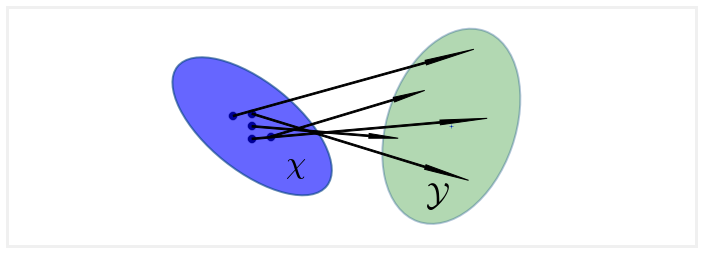

In [9]:
ukf_internal.show_sigma_transform(with_text=True)

We then compute the new mean and covariance using these equations.

$$\begin{aligned}
\mu &= \sum_i w_i\boldsymbol{\mathcal{Y}}_i \\
\Sigma &= \sum_i w_i{(\boldsymbol{\mathcal{Y}}_i-\mu)(\boldsymbol{\mathcal{Y}}_i-\mu)^\mathsf{T}}
\end{aligned}
$$

These equations should be familar - they are just the constraint equations we developed above. They perhaps don't look like much, but let's see an example of their power.

Earlier we wrote a function that found the mean of a distribution by passing 50,000 points through a nonlinear function. Let's now use 5 sigma points - we will pass them through the nonlinear function, and compute their mean with the unscented transform. This code is below. Under the comment `### create sigma points` I use code from FilterPy to generate the sigma points. It uses functionality which you will learn later in this chapter; pass by it for now. The key points are we generate 5 points deterministically, pass them through the nonlinear function, and then run the unscented transform on them to generate the estimated mean.

Difference in mean x=0.032, y=0.245


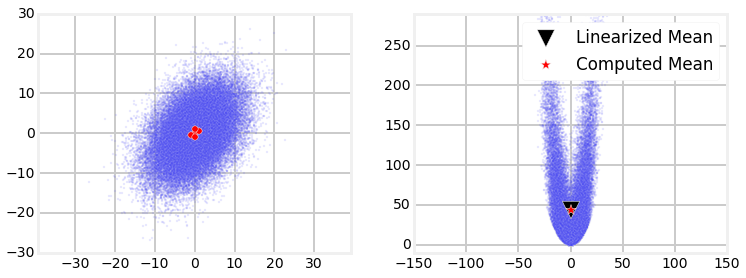

In [10]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints

def f_nonlinear_xy(x, y):
    return np.array([x + y, .1*x**2 + y*y])

mean = (0, 0)
p = np.array([[32., 15],
              [15., 40.]])

### create sigma points
points = MerweScaledSigmaPoints(n=2, alpha=.1, beta=2., kappa=1.)
Wm, Wc = points.weights()
sigmas = points.sigma_points(mean, p)

### pass through nonlinear function
sigmas_f = np.zeros((5, 2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas[i, 0], sigmas[i ,1])

### pass through unscented transform
ukf_mean, _ = unscented_transform(sigmas_f, Wm, Wc)

#generate random points
xs, ys = multivariate_normal(mean=mean, cov=p, size=50000).T

monte_carlo_mean(xs, ys, f, ukf_mean, 'UKF Mean')
plt.subplot(121)
plt.scatter(sigmas[:,0], sigmas[:,1], c='r', s=40)
plt.show()

I find this result remarkable. Using only 5 points we were able to compute the mean with amazing accuracy. The error in x is only 0.054, and the error in y is 0.408. In contrast, a linearized approach (used by the predominant EKF filter) gave an error of over 43 in y. I told you to ignore the code to generate the sigma points, but if you look at it you'll see that it has no knowledge of the nonlinear function, only of the mean and covariance of our initial distribution. The same 5 sigma points would be generated if we had a completely different nonlinear function. 

I will admit to choosing a nonlinear function that makes the performance of the unscented tranform striking compared to the EKF. But the physical world is filled with very nonlinear behavior, and the UKF takes it in stride. You will see in the next chapter how more traditional techniques struggle with strong nonlinearities. This graph is the foundation of why I advise you to use the UKF or similar modern technique whenever possible.

> The UKF belongs to a family of filters called sigma point filters. By the end of this chapter you will be prepared to do a literature search and learn about the various sigma point filters that have been invented.

## The Unscented Filter

Now we can present the entire Unscented Kalman filter algorithm. As discussed earlier assume that there is a function $f(x, dt)$ that performs the state transition for our filter - it predicts the next state given the current state. Also assume there is a measurement function $h(x)$  - it takes the current state and computes what measurement that state corresponds to. These are just nonlinear forms of the $\mathbf{F}$ and $\mathbf{H}$ matrices used by the linear Kalman filter.

### Predict Step

As with the linear Kalman filter, the UKF's predict step computes the mean and covariance of the system for the next epoch using the process model. However, the computation is quite different.

First, we generate the weights and sigma points as specified above.

$$\begin{aligned}
\mathcal{X} &= sigma\_function(\bf{\mu}, \bf{\Sigma}) \\
W &= weight\_function()\end{aligned}$$

We pass each sigma point through the function f. This projects the sigma points forward in time according to our process model.

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi})$$

Now we compute the predicted mean and covariance using the *unscented transform *on the transformed sigma points. I've dropped the subscript $i$ for readability.

$$\begin{aligned}
\mathbf{\mu}^- &= \sum w^m\boldsymbol{\mathcal{Y}} \\
\mathbf{\Sigma}^- &= \sum w^c({\boldsymbol{\mathcal{Y}}-\bf{\mu}^-)(\boldsymbol{\mathcal{Y}}-\bf{\mu}^-)^\mathsf{T}} + \mathbf{Q}
\end{aligned}
$$

This computes the mean and covariance represented by the green ellipse above, and corresponds with the linear Kalman filter equations of

$$ \begin{aligned}
\mathbf{x}^- &= \mathbf{Fx}\\
\mathbf{P}^- &= \mathbf{FPF}^\mathsf{T}+\mathbf{Q}
\end{aligned}$$

### Update Step

Now we can perform the update step of the filter. Recall that Kalman filters perform the update state in measurement space. So, the first thing we do is convert the sigma points from the predict step into measurements using the $h(x)$ function that you define.

$$\boldsymbol{\mathcal{Z}} = h(\boldsymbol{\mathcal{Y}})$$

Now we can compute the mean and covariance of these points using the unscented transform.

$$\begin{aligned}
\mathbf{\mu}_z &= \sum w^m\boldsymbol{\mathcal{Z}} \\
\mathbf{P}_z &= \sum w^c{(\boldsymbol{\mathcal{Z}}-\mu^-)(\boldsymbol{\mathcal{Z}}-\mu^-)^\mathsf{T}} + \mathbf{R}
\end{aligned}
$$

The $z$ subscript denotes that these are the mean and covariance for the measurements.

All that is left is to compute the residual and Kalman gain. The residual is trivial to compute:

$$\mathbf{y} = \boldsymbol{\mathcal{Z}} - \boldsymbol{\mu}_z$$


The Kalman gain is not much worse. We have to compute the cross variance of the state and the measurements, which we state without proof to be: 

$$\mathbf{P}_{xz} =\sum w^c(\boldsymbol{\chi}-\mu)(\boldsymbol{\mathcal{Z}}-\mathbf{\mu}_z)^\mathsf{T}$$

And then the Kalman gain is defined as

$$K = \mathbf{P}_{xz} \mathbf{P}_z^{-1}$$

Finally, we compute the new state estimate using the residual and Kalman gain:

$$\hat{\mathbf{x}} = \mathbf{x}^- + \mathbf{Ky}$$

and the new covariance is computed as:

$$ \hat{\mathbf{P}} = \mathbf{\Sigma}^- - \mathbf{KP_z}\mathbf{K}^\mathsf{T}$$

This step contains a few equations you have to take on faith, but you should be able to see how they relate to the linear Kalman filter equations. We convert the mean and covariance into measurement space, add the measurement error into the measurement covariance, compute the residual and kalman gain, compute the new state estimate as the old estimate plus the residual times the Kalman gain, and then convert both back into state space. The linear algebra is slightly different from the linear Kalman filter, but the algorithm is the same.

## Using the UKF

We are now ready to consider implementing an unscented Kalman filter. All of the math is above is already implemented in FilterPy, and you are perhaps a bit lost at this point, so lets just launch into solving some problems so you can gain confidence in how easy the UKF actually is. Later we will revisit how the UKF is implemented in Python.


Let's start by solving a problem you already know how to do. Although the UKF was designed for nonlinear problems, it works fine on linear problems. In fact, it is guaranteed to get the same result as the linear Kalman filter for linear problems. We will write a solver for the linear problem of tracking using a constant velocity model in 2D. This will allows us to focus on what is the same (and most is the same!) and what is different with the UKF. 

To design a linear Kalman filter you need to design the $\bf{x}$, $\bf{F}$, $\bf{H}$, $\bf{R}$, and $\bf{Q}$ matrices. We have done this many times already so let me just present a design to you without a lot of comment. We want a constant velocity model, so we can define $\bf{x}$ to be

$$ \mathbf{x} = \begin{bmatrix}x &  \dot{x} & y & \dot{y} \end{bmatrix}^\mathsf{T}$$.

With this ordering of state variables we can define our state transition model to be

$$\mathbf{F} = \begin{bmatrix}1 & \Delta t & 0 & 0 \\
0&1&0&0 \\
0&0&1&\Delta t\\
0&0&0&1
\end{bmatrix}$$

which implements the Newtonian equation

$$x_k = x_{k-1} + \dot{x}_{k-1}\Delta t$$

Our sensors provide position measurements but not velocity, so the measurement function is

$$\mathbf{H} = \begin{bmatrix}1&0&0&0 \\ 0&0&1&0
\end{bmatrix}$$

Let's say our sensor gives positions in meters with an error of $1\sigma=0.3$ meters in both the *x* and *y* coordinates. This gives us a measurement noise matrix of 

$$\mathbf{R} = \begin{bmatrix}0.3^2 &0\\0 & 0.3^2\end{bmatrix}$$

Finally, let's assume that the process noise can be represented by the discrete white noise model - that is, that over each time period the acceleration is constant. We can use `FilterPy`'s `Q_discrete_white_noise()` method to create this matrix for us, but for review the matrix is

$$\mathbf{Q} = \begin{bmatrix}
\frac{1}{4}\Delta t^4 & \frac{1}{2}\Delta t^3 \\
\frac{1}{2}\Delta t^3 & \Delta t^2\end{bmatrix} \sigma^2$$

Our implementation might look like this:

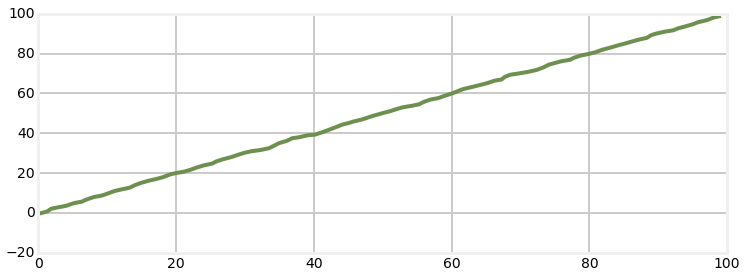

In [11]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from numpy import random

sigma_x, sigma_y = .3, .3
dt = 1.0

random.seed(1234)
kf = KalmanFilter(4, 2)
kf.x = np.array([0., 0., 0., 0.])
kf.R = np.diag([sigma_x**2, sigma_y**2])
kf.F = np.array([[1, dt, 0, 0], 
                 [0, 1, 0, 0],
                 [0, 0, 1, dt],
                 [0, 0, 0, 1]])
kf.H = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0]])
 
kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)

zs = [np.array([i + randn()*sigma_x, i + randn()*sigma_y]) for i in range(100)]               
xs, _, _, _ = kf.batch_filter(zs)
plt.plot(xs[:, 0], xs[:, 2])
plt.show()

This should hold no surprises for you. Now let's implement this filter as an Unscented Kalman filter. Again, this is purely for educational purposes; using a UKF for a linear filter confers no benefit.

The equations of the UKF are implemented for you with the `FilterPy` class `UnscentedKalmanFilter`; all you have to do is specify the matrices and the nonlinear functions `f(x)` and `h(x)`. `f(x)` implements the state transition function that is implemented by the matrix $\mathbf{F}$ in the linear filter, and `h(x)` implements the measurement function implemented with the matrix $\mathbf{H}$. In nonlinear problems these functions are nonlinear, so we cannot use matrices to specify them.

For our linear problem we can just define these functions to implement the linear equations. The function `f(x)` takes the signature `def f(x,dt)` and `h(x)` takes the signature `def h(x)`. Below is a reasonable implementation of these two functions. Each is expected to return a 1-D NumPy array with the result.

In [12]:
def f_cv(x, dt):
    """ state transition function for a constant velocity aircraft"""
    
    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]])
    return np.dot(F, x)

def h_cv(x):
    return np.array([x[0], x[2]])

You need to tell the filter how to compute the sigma points and weights. We gave the Van der Merwe's scaled unscented transform version above, but there are many different choices. FilterPy uses a `SigmaPoints` class which must implement two methods:

    def sigma_points(self, x, P)
    def weights(self)
    
FilterPy provides the class `MerweScaledSigmaPoints`, which implements the sigma point algorithm in this chapter.

Other than these two functions, everything else is nearly the same. When you create the UKF you will pass in the two functions and sigma point class object like so:

    from filterpy.kalman import MerweScaledSigmaPoints
    from filterpy.kalman import UnscentedKalmanFilter as UKF
    
    points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1)
    ukf = UKF(dim_x=4, dim_z=2, fx=f_cv, hx=h_cv, dt=dt, points=points)

The rest of the code is the same as for the linear kalman filter. Let's just implement it! I'll use the same measurements as used by the linear Kalman filter, and compute the standard deviation of the difference between the two solution. I will use the `batch_filter` method to keep the code succinct; for clarity I put the equivalent iterative loop in a comment. As with all the filters we have done to date you ju

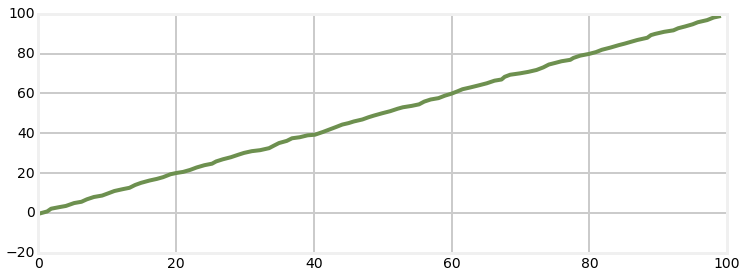

UKF standard deviation 0.013


In [13]:
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF

import numpy as np

sigmas = MerweScaledSigmaPoints(4, alpha=.1, beta=2., kappa=1.)
ukf = UKF(dim_x=4, dim_z=2, fx=f_cv, hx=h_cv, dt=dt, points=sigmas)
ukf.x = np.array([0., 0., 0., 0.])
ukf.R = np.diag([0.09, 0.09]) 
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)

uxs = []
for z in zs:
    ukf.predict()
    ukf.update(z)
    uxs.append(ukf.x.copy())
uxs = np.array(uxs)

plt.plot(uxs[:, 0], uxs[:, 2])
plt.show()
print('UKF standard deviation {:.3f}'.format(np.std(uxs - xs)))

This gave me a standard deviation 0f 0.013 which is quite small. 

You can see that there is not much difference in the implementation of the UKF vs linear Kalman filter. We merely replace $\mathbf{F}$ with the function *f(x)*, and the matrix $\mathbf{H}$ with the function *h(x)*. The rest of the theory and implementation remains the same. Well, of course under the hood the `FilterPy` implementation is quite different than the Kalman filter code, but from a designer's point of view the problem formulation and filter design is very similar.

## Tracking a Flying Airplane

### First Attempt

Let's tackle our first nonlinear problem. To minimize the number of things that change I will keep the problem formulation very similar to the linear tracking problem above. For this problem we will write a filter to track a flying airplane using a stationary radar as the sensor. To keep the problem as close to the previous one as possible we will track in two dimensions, not three. We will track one dimension on the ground and the altitude of the aircraft. The second dimension on the ground adds no difficulty or different information, so we can do this with no loss of generality.

 Radars work by emitting a beam of radio waves and scanning for a return bounce. Anything in the beam's path will reflect some of the signal back to the radar. By timing how long it takes for the reflected signal to get back to the radar the system can compute the *slant distance* - the straight line distance from the radar installation to the object. We also get the bearing to the target. For this 2D problem that will be the angle above the ground plane. True integration of sensors for applications like military radar and aircraft navigation systems have to take many factors into account which I am not currently interested in trying to cover in this book. So if any practitioners in the the field are reading this they will be rightfully scoffing at my exposition. My only defense is to argue that I am not trying to teach you how to design a military grade radar tracking system, but instead trying to familiarize you with the implementation of the UKF. 
 
For this example we want to take the slant range measurement from the radar and compute the horizontal position (distance of aircraft from the radar measured over the ground) and altitude of the aircraft, as in the diagram below.

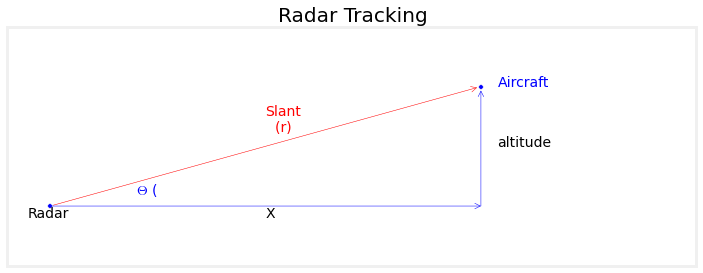

In [14]:
import ekf_internal
ekf_internal.show_radar_chart()

We will assume that the aircraft is flying at a constant altitude, so a three variable state vector will work.

$$\mathbf{x} = \begin{bmatrix}distance \\velocity\\ altitude\end{bmatrix}=  \begin{bmatrix}x_{pos} \\x_{vel}\\ x_{alt}\end{bmatrix}$$

Our state transition function is linear 

$$\mathbf{x}^- = \begin{bmatrix} 1 & \Delta t & 0 \\ 0& 1& 0 \\ 0&0&1\end{bmatrix}
\begin{bmatrix}x_{pos} \\x_{vel}\\ x_{alt}\end{bmatrix} 
$$

and we can implement that very much like we did for the previous problem.

In [15]:
def f_radar(x, dt):
    """ state transition function for a constant velocity aircraft
    with state vector [x, velocity, altitude]'"""
    
    F = np.array([[1, dt, 0],
                  [0,  1, 0],
                  [0,  0, 1]], dtype=float)
    return np.dot(F, x)

The next step is to design the measurement function. As in the linear Kalman filter the measurement function converts the filter's state into a measurement. So for this problem we need the position and velocity of the aircraft and convert it to the bearing and range from the radar station.

If we represent the position of the radar station with an (x,y) coordinate computation of the range and bearing is straightforward. To compute the range we use the Pythagorean theorem:

$$range = \sqrt{(x_{ac} - x_{radar})^2 + (z_{ac} - z_{radar})^2}$$

To compute the bearing we need to use the arctangent function.

$$bearing = \tan^{-1}{\frac{z_{ac} - z_{radar}}{x_{ac} - x_{radar}}}$$

As with the state transition function we need to define a Python function to compute this for the filter. I'll take advantage of the fact that a function can own a variable to store the radar's position.

In [16]:
def h_radar(x):
    dx = x[0] - h_radar.radar_pos[0]
    dz = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dz**2)
    bearing = math.atan2(dz, dx)
    return slant_range, bearing

h_radar.radar_pos = (0, 0)

**Important Note**: There is a nonlinearity that we are not considering, the fact that angles are modular. Kalman filters operate by computing the differences between measurements. The difference between $359^\circ$ and $1^\circ$ is $2^\circ$, but a subtraction of the two values, as implemented by the filter, yields a value of $358^\circ$. This is exacerbated by the UKF which computes sums of weighted values in the unscented transform. For now we will place our sensors and targets in positions that avoid these nonlinear regions. Later in the chapter I will show you how to handle this problem.

We need to simulate the Radar station and the movement of the aircraft. By now this should be second nature for you, so I will present the code without much discussion.

In [17]:
from numpy.linalg import norm
from math import atan2

class RadarStation(object):
    
    def __init__(self, pos, range_std, bearing_std):
        self.pos = np.asarray(pos)
        
        self.range_std = range_std
        self.bearing_std = bearing_std

    
    def reading_of(self, ac_pos):
        """ Returns actual range and bearing to aircraft as tuple. 
        Bearing is in radians.
        """
        
        diff = np.subtract(ac_pos, self.pos)
        rng = norm(diff)
        brg = atan2(diff[1], diff[0])
        return rng, brg


    def noisy_reading(self, ac_pos):
        """ Compute range and bearing to aircraft with simulated noise"""
        
        rng, brg = self.reading_of(ac_pos)      
        rng += randn() * self.range_std
        brg += randn() * self.bearing_std 
        return rng, brg
        
   
class ACSim(object):
    
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std
        
        
    def update(self, dt):
        """ compute next position. Incorporates random variation in
        velocity. Returns new position."""
        
        vel = self.vel*dt + (randn() * self.vel_std) * dt      
        self.pos += vel
        
        return self.pos

Now let's put it all together. A military grade radar system can achieve 1 meter RMS range accuracy, and 1 mrad RMS for bearing [1]. We will assume a more modest 5 meter range accuracy, and 0.5$^\circ$ angular accuracy as this provides a more challenging data set for the filter.

I'll start with the aircraft positioned directly over the radar station, flying away from it at 100 m/s. A typical radar might update only once every 12 seconds and so we will use that for our update period. 

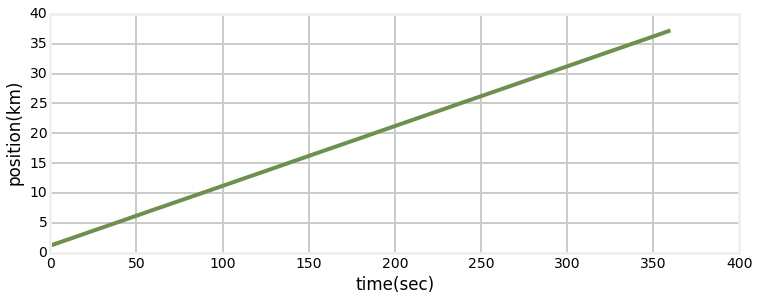

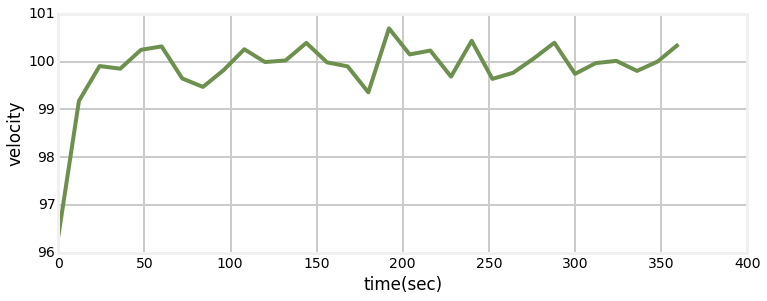

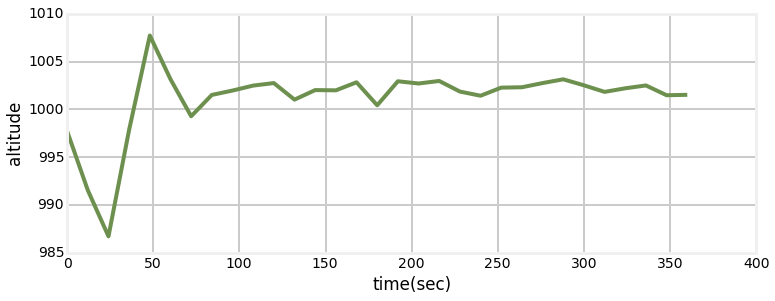

In [18]:
from filterpy.common import Q_discrete_white_noise
import math

dt = 12. # 12 seconds between readings

range_std = 5 # meters
bearing_std = math.radians(0.5)

ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos

points = MerweScaledSigmaPoints(n=3, alpha=.1, beta=2., kappa=0.)
kf = UKF(3, 2, dt, fx=f_radar, hx=h_radar, points=points)

kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2, 2] = 0.1

kf.R = np.diag([range_std**2, bearing_std**2])
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])


radar = RadarStation(pos=(0, 0), range_std=range_std, bearing_std=bearing_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

random.seed(200)

t = np.arange(0, 360 + dt, dt)
n = len(t)

xs = []
for i in range(len(t)):
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)
   
def plot_radar(xs, t, plot_x=True, plot_vel=True, plot_alt=True):
    
    xs = np.asarray(xs)
    if plot_x:
        plt.figure()
        plt.plot(t, xs[:, 0]/1000.)
        plt.xlabel('time(sec)')
        plt.ylabel('position(km)')
        
    if plot_vel:
        plt.figure()
        plt.plot(t, xs[:, 1])
        plt.xlabel('time(sec)')
        plt.ylabel('velocity')

    if plot_alt:
        plt.figure()
        plt.plot(t, xs[:,2])
        plt.xlabel('time(sec)')
        plt.ylabel('altitude')
        plt.show()
    
plot_radar(xs, t)

This may or may not impress you, but it impresses me! In the Extended Kalman filter chapter we will solve the same problem, but it will take significant amounts of mathematics to handle the same problem. 

### Tracking Manuevering Aircraft

The previous example produced extremely good results, but it also relied on an assumption of an aircraft flying at a constant speed with no change in altitude. I will relax that assumption by allowing the aircraft to change altitude. First, let's see the performance of the previous code if the aircraft starts climbing after one minute.

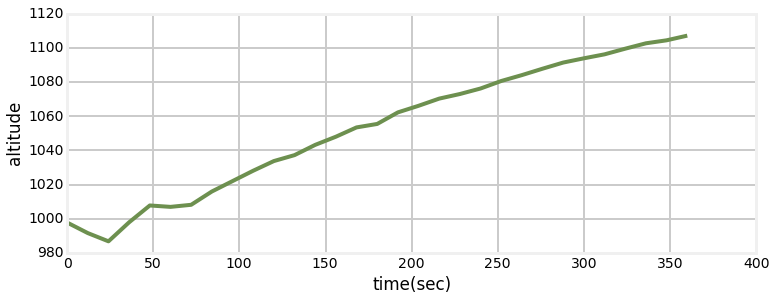

Actual altitude: 2561.9
UKF altitude   : 1107.2


In [19]:
# reset aircraft position
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])
ac = ACSim(ac_pos, (100, 0), 0.02)

random.seed(200)

t = np.arange(0, 360 + dt, dt)
n = len(t)

xs = []
for i in t:
    if i >= 60:
        ac.vel[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)

plot_radar(xs, t, plot_x=False, plot_vel=False, plot_alt=True)
print('Actual altitude: {:.1f}'.format(ac.pos[1]))
print('UKF altitude   : {:.1f}'.format(xs[-1][2]))

the performance is terrible as the filter is completely unable to track the changing altitude. What do we have to change to allow the filter to track the aircraft?

I hope you answered add climb rate to the state, like so:


$$\mathbf{x} = \begin{bmatrix}distance \\velocity\\ altitude \\ climb rate\end{bmatrix}=  \begin{bmatrix}x \\\dot{x}\\ z \\ \dot{z}\end{bmatrix}$$

This requires the following change to the state transition function, which is still linear.

$$\mathbf{x}^- = \begin{bmatrix} 1 & \Delta t & 0 &0 \\ 0& 1& 0 &0\\ 0&0&1&dt \\ 0&0&0&1\end{bmatrix}
\begin{bmatrix}x \\\dot{x}\\ z\\ \dot{z}\end{bmatrix} 
$$

The measurement function stays the same, but we will have to alter Q to account for the state dimensionality change.

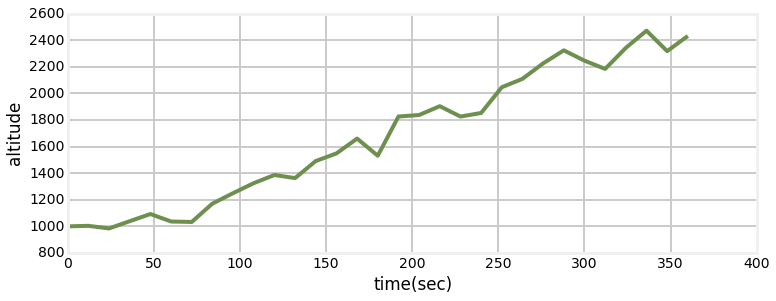

Actual altitude: 2561.9
UKF altitude   : 2432.9


In [20]:
def f_cv_radar(x, dt):
    """ state transition function for a constant velocity aircraft"""
    
    F = np.array([[1, dt, 0, 0],
                  [0,  1, 0, 0],
                  [0,  0, 1, dt],
                  [0,  0, 0, 1]], dtype=float)
    return np.dot(F, x)

ac = ACSim(ac_pos, (100, 0), 0.02)

points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1.)
kf = UKF(4, 2, dt, fx=f_cv_radar, hx=h_radar, points=points)

kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=dt, var=0.1)

kf.R = np.diag([range_std**2, bearing_std**2])
kf.x = np.array([0., 90., 1100., 0.])
kf.P = np.diag([300**2, 3**2, 150**2, 3**2])

random.seed(200)

t = np.arange(0, 360 + dt, dt)
n = len(t)

xs = []
for i in t:
    if i >= 60:
        ac.vel[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)

plot_radar(xs, t, plot_x=False, plot_vel=False, plot_alt=True)
print('Actual altitude: {:.1f}'.format(ac.pos[1]))
print('UKF altitude   : {:.1f}'.format(xs[-1][2]))

We can see that a significant amount of noise has been introduced into the altitude, but we are now accurately tracking the altitude change. 

### Sensor Fusion

Now let's consider a simple example of sensor fusion. Suppose we have some type of Doppler system that produces a velocity estimate with 2 m/s RMS accuracy. I say "some type" because as with the radar I am not trying to teach you how to create an accurate filter for a Doppler system, where you have to account for the signal to noise ratio, atmospheric effects, the geometry of the system, and so on. 

The accuracy of the radar system in the last examples allowed us to estimate velocities to within a m/s or so, so we have to degrade that accuracy to be able to easily see the effect of the sensor fusion. Let's change the range error to 500 meters and then compute the standard deviation of the computed velocity. I'll skip the first several measurements because the filter is converging during that time, causing artificially large deviations.

Velocity standard deviation 3.4 m/s


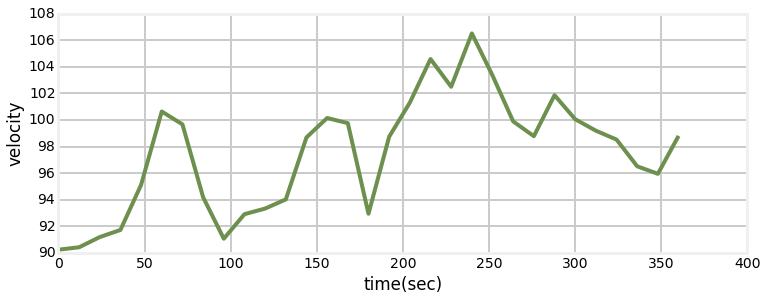

In [21]:
range_std = 500.
bearing_std = math.degrees(0.5)
radar = RadarStation(pos=(0, 0), range_std=range_std, bearing_std=bearing_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1.)
kf = UKF(4, 2, dt, fx=f_cv_radar, hx=h_radar, points=points)

kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=dt, var=0.1)

kf.R = np.diag([range_std**2, bearing_std**2])
kf.x = np.array([0., 90., 1100., 0.])
kf.P = np.diag([300**2, 3**2, 150**2, 3**2])

random.seed(200)

t = np.arange(0, 360 + dt, dt)
n = len(t)

xs = []
for i in t:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)

xs = np.asarray(xs)
plot_radar(xs, t, plot_x=False, plot_vel=True, plot_alt=False)
print('Velocity standard deviation {:.1f} m/s'.format(np.std(xs[10:, 1])))

Velocity standard deviation 1.3 m/s


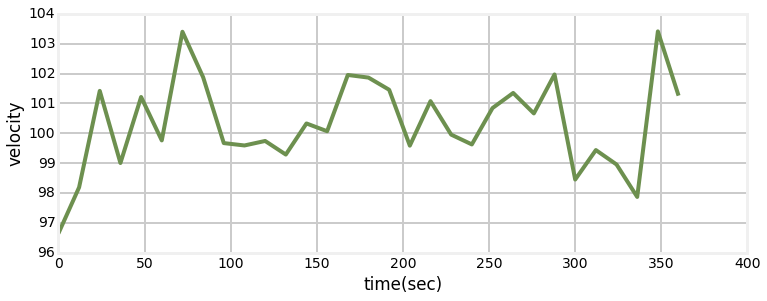

In [22]:
def h_vel(x):
    dx = x[0] - h_vel.radar_pos[0]
    dz = x[2] - h_vel.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dz**2)
    bearing = math.atan2(dz, dx)
    return slant_range, bearing, x[1], x[3]

h_vel.radar_pos = (0, 0)

range_std = 500.
bearing_std = math.degrees(0.5)
radar = RadarStation(pos=(0, 0), range_std=range_std, bearing_std=bearing_std)
vel_std = 2.

ac = ACSim(ac_pos, (100, 0), 0.02)
points = MerweScaledSigmaPoints(n=4, alpha=.2, beta=2., kappa=-1.)
kf = UKF(4, 4, dt, fx=f_cv_radar, hx=h_vel, points=points)

kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=dt, var=0.1)

kf.R = np.diag([range_std**2, bearing_std**2, vel_std**2, vel_std**2])
kf.x = np.array([0., 90., 1100., 0.])
kf.P = np.diag([300**2, 3**2, 150**2, 3**2])

random.seed(200)

t = np.arange(0, 360 + dt, dt)
n = len(t)

xs = []
for i in t:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    vx = ac.vel[0] + randn()*vel_std
    vz = ac.vel[1] + randn()*vel_std
    kf.predict()
    kf.update([r[0], r[1], vx, vz]) 
    xs.append(kf.x)
xs = np.asarray(xs)
plot_radar(xs, t, plot_x=False, plot_vel=True, plot_alt=False)
print('Velocity standard deviation {:.1f} m/s'.format(np.std(xs[10:,1])))

By incorporating the velocity sensor we were able to reduce the standard deviation from 3.5 m/s to 1.3 m/s. 

Sensor fusion is a large topic, and this is a rather simplistic implementation. In a typical navigation problem we have sensors that provide *complementary* information. For example, a GPS might provide somewhat accurate position updates once a second with poor velocity estimation while an inertial system might provide very accurate velocity updates at 50Hz but terrible position estimates. The strengths and weaknesses of each sensor are orthogonal to each other. This leads to something called the *Complementary filter*, which uses the high update rate of the inertial sensor with the position accurate but slow estimates of the GPS to produce very high rate yet very accurate position and velocity estimates. This will be the topic of a future chapter. 

### Multiple Position Sensors

The last sensor fusion problem was somewhat a toy example due to the existence of techniques like the *Complementary filter*. Let's tackle a problem that is not so toy-like. Before the advent of GPS ships and aircraft navigated via various range and bearing systems such as VOR, LORAN, TACAN, DME, and so on. I do not intend to cover the intricacies of these systems - Wikipedia will fill the basics if you are interested. In general these systems are beacons that allow you to extract either the range, bearing, or range and bearing to the beacon. For example, an aircraft might have two VOR receivers. The pilot tunes each receiver to a different VOR station. Each VOR receiver displays what is called the "radial" - the direction from the VOR station on the ground to the aircraft. Using a chart they can extend these two radials - the intersection point is the position of the aircraft.

That is a very manual and low accuracy approach. We can use a Kalman filter to filter the data and produce far more accurate position estimates. Let's work through that.

The problem is as follows. Assume we have two sensors, each which provides a bearing only measurement to the target, as in the chart below. In the chart the width of the circle is intended to denote a different amount of sensor noise.

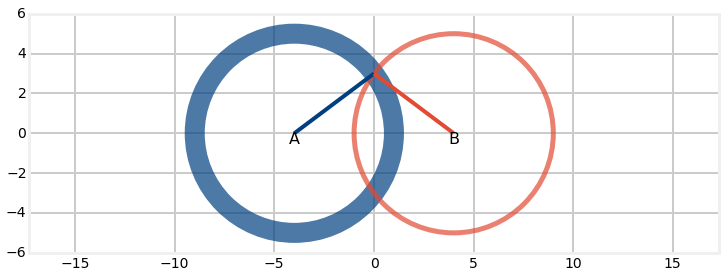

In [23]:
ukf_internal.show_two_sensor_bearing()

We can compute the bearing between a sensor and the target as follows:

    def bearing(sensor, target):
        return math.atan2(target[1] - sensor[1], target[0] - sensor[0])

So our filter will need to receive a vector of 2 measurements during each update, one for each sensor. We can implement that as:

    def measurement(A_pos, B_pos, pos):
        angle_a = bearing(A_pos, pos)
        angle_b = bearing(B_pos, pos)
        return [angle_a, angle_b]

The design of the measurement function and state transition function can remain the same as nothing has changed that would affect them. 

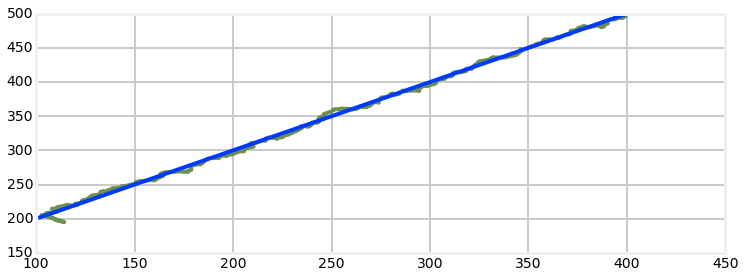

In [24]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.common import Q_discrete_white_noise

sa_pos = [-400, 0]
sb_pos = [400, 0]

def bearing(sensor, target_pos):
    return math.atan2(target_pos[1] - sensor[1], target_pos[0] - sensor[0])

def measurement(A_pos, B_pos, pos):
    angle_a = bearing(A_pos, pos)
    angle_b = bearing(B_pos, pos)
    return [angle_a, angle_b]

def fx_VOR(x, dt):
    x[0] += x[1]
    x[2] += x[3]
    return x


def hx_VOR(x):
    # measurement to A
    pos = (x[0], x[2])
    return measurement(sa_pos, sb_pos, pos)


def moving_target_filter(target_pos, std_noise, Q, dt=0.1, kappa=0.0):
    points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=kappa)
    f = UKF(dim_x=4, dim_z=2, dt=dt, hx=hx_VOR, fx=fx_VOR, points=points)
    f.x = np.array([target_pos[0], 1., target_pos[1], 1.])

    q = Q_discrete_white_noise(2, dt, Q)
    f.Q[0:2, 0:2] = q
    f.Q[2:4, 2:4] = q

    f.R *= std_noise**2
    f.P *= 1000
    
    return f


def plot_straight_line_target(f, std_noise):
    xs = []
    txs = []

    for i in range(300):
        target_pos[0] += 1 + randn()*0.0001
        target_pos[1] += 1 + randn()*0.0001
        txs.append((target_pos[0], target_pos[1]))

        z = measurement(sa_pos, sb_pos, target_pos)
        z[0] += randn() * std_noise
        z[1] += randn() * std_noise

        f.predict()
        f.update(z)
        xs.append(f.x)

    xs = np.asarray(xs)
    txs = np.asarray(txs)

    plt.plot(xs[:, 0], xs[:, 2])
    plt.plot(txs[:, 0], txs[:, 1])
    plt.show()
 
np.random.seed(123)
target_pos = [100, 200]

std_noise = math.radians(0.5)
f = moving_target_filter(target_pos, std_noise, Q=1.0)
plot_straight_line_target(f, std_noise)

This looks quite good to me. There is a very large error at the beginning of the track, but the filter is able to settle down and start producing good data.

Let's revisit the nonlinearity of the angles. I will position the target between the two sensors with the same y-coordinate. This will cause a nonlinearity in the computation of the sigma means and the residuals because the mean angle will be near zero. As the angle goes below 0 the measurement function will compute a large positive angle of around $2\pi$. The residual between the prediction and measurement will thus be very large, nearly $2\pi$ instead of nearly 0. This makes it impossible for the filter to perform accurately, as seen in the example below.

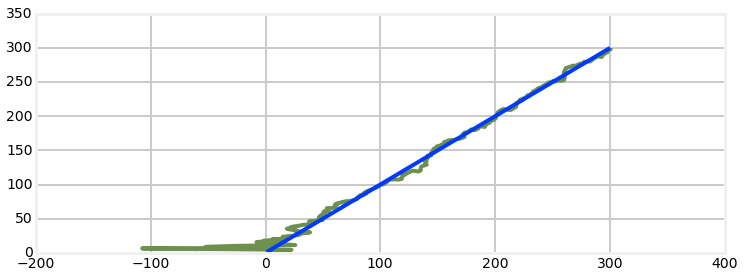

In [25]:
target_pos = [0, 0]
f = moving_target_filter(target_pos, std_noise, Q=1.0)
plot_straight_line_target(f, std_noise)

This is untenable behavior for a real world filter. `FilterPy`'s UKF code allows you to provide it a function to compute the residuals in cases of nonlinear behavior like this, but this requires more knowledge about `FilterPy`'s implementation than we yet process.

Finally, let's discuss the sensor fusion method that we used. We used the measurement from each bearing and had the Kalman filter's equations compute the world position from the measurements. This is equivalent to doing a weighted least squares solution. In the *Kalman Filter Math* chapter we discussed the limited accuracy of such a scheme and introduced an *Iterative Least Squares* (ILS) algorithm to produce greater accuracy. If you wanted to use that scheme you would write an ILS algorithm to solve the geometry of your problem, and pass the result of that calculation into the `update()` method as the measurement to be filtered. This imposes on you the need to compute the correct noise matrix for this computed positions, which may not be trivial. Perhaps in a later release of this book I will develop an example, but regardless it will take you a significant amount of research and experiment to design the best method for your application. For example, the ILS is probably the most common algorithm used to turn GPS pseudoranges into a position, but the literature discusses a number of alternatives. Sometimes there are faster methods, sometimes the iterative method does not converge, or does not converge fast enough, or requires too much computation for an embedded system. 

## Exercise: Track a target moving in a circle

Change the simulated target movement to move in a circle. Avoid angular nonlinearities by putting the sensors well outside the movement range of the target, and avoid the angles $0^\circ$ and $180^\circ$.

In [26]:
# your solution here

### Solution

We have a few choices here. First, if we know the movement of the target we can design our filter's state transition function so that it correctly predicts the circular movement. For example, suppose we were tracking a boat race optically - we would want to take track shape into account with our filter. However, in this chapter we have not been talking about such constrained behavior, so I will not build knowledge of the movement into the filter. So my implementation looks like this.

In [27]:
def plot_circular_target(f, std_noise, target_pos):
    xs = []
    txs = []
    radius = 100
    for i in range(300):
        target_pos[0] = math.cos(i/10)*radius + randn()*0.0001
        target_pos[1] = math.sin(i/10)*radius + randn()*0.0001
        txs.append((target_pos[0], target_pos[1]))

        z = measurement(sa_pos, sb_pos, target_pos)
        z[0] += randn() * std_noise
        z[1] += randn() * std_noise

        f.predict()
        f.update(z)
        xs.append(f.x)

    xs = np.asarray(xs)
    txs = np.asarray(txs)

    plt.plot(xs[:, 0], xs[:, 2])
    plt.plot(txs[: ,0], txs[:, 1], linestyle='-.')
    plt.axis('equal')
    plt.show()

sa_pos = [-240, 200]
sb_pos = [240, 200]

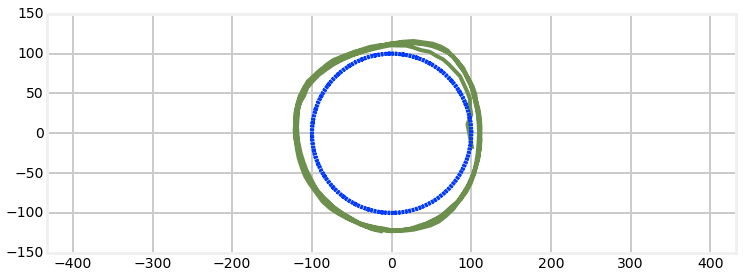

In [28]:
np.random.seed(12283)
std_noise = math.radians(0.5)
target_pos = [0, 0]
f = moving_target_filter(target_pos, std_noise, Q=1.1)
plot_circular_target(f, std_noise, target_pos)

### Discussion

The filter tracks the movement of the target, but never really converges on the track.  This is because the filter is modeling a constant velocity target, but the target is anything but constant velocity. As mentioned above we could model the circular behavior by defining the `fx()` function, but then we would have problems when the target is not moving in a circle. Instead, lets tell the filter we are are less sure about our process model by making $\mathbf{Q}$ larger. Here I have increased the variance from 0.1 to 1.0

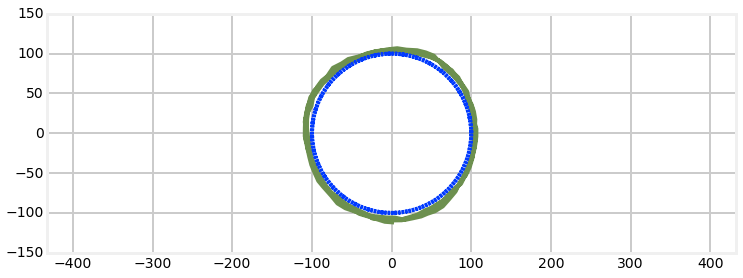

In [29]:
np.random.seed(12283)
std_noise = math.radians(0.5)
cf = moving_target_filter(target_pos, std_noise, Q=10.)
target_pos = [0, 0]
plot_circular_target(cf, std_noise, target_pos)

The convergence is not perfect, but it is far better. 

## Exercise: Sensor Position Effects

Is the behavior of the filter invariant for any sensor position? Find a sensor position that produces bad filter behavior.

In [30]:
# your answer here

### Solution

We have already discussed the problem of angles being modal, so causing that problem by putting the sensors at `y=0` would be a trivial solution. However, let's be more subtle than that. We want to create a situation where there are an infinite number of solutions for the sensor readings. We can achieve that whenever the target lies on the straight line between the two sensors. In that case there is no triangulation possible and there is no unique solution. My solution is as follows.

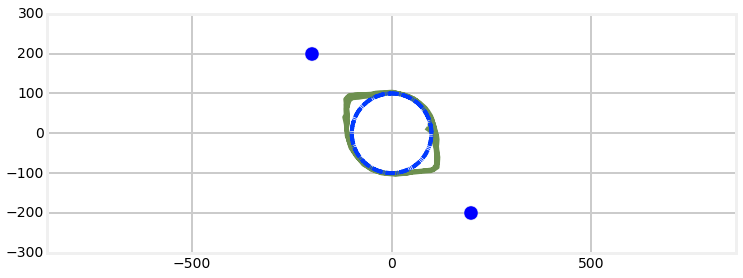

In [31]:
std_noise = math.radians(0.5)
sa_pos = [-200, 200]
sb_pos = [200, -200]
plt.scatter(*sa_pos, s=200)
plt.scatter(*sb_pos, s=200)
target_pos = [0, 0]
cf = moving_target_filter(target_pos, std_noise, Q=10.)
plot_circular_target(cf, std_noise, target_pos)

I put the sensors at the upper left hand side and lower right hand side of the target's movement. We can see how the filter diverges when the target enters the region directly between the two sensors. The state transition always predicts that the target is moving in a straight line. When the target is between the two sensors this straight line movement is well described the bearing measurements from the two sensors so the filter estimate starts to approximate a straight line. 

## Exercise: Compute Position Errors

The position errors of the filter vary depending on how far away the target is from a sensor. Write a function that computes the distance error due to a bearing error. 

In [32]:
# your solution here

### Solution

Basic trigonometry gives us this answer.

In [33]:
def distance_error(target_distance, angle_error):
    x = 1 - math.cos(angle_error)
    y = math.sin(angle_error)
    return target_distance*(x**2 + y**2)**.5

d = distance_error(100, math.radians(1.))
print('\n\nError of 1 degree at 100km is {:.3}km'.format(d))



Error of 1 degree at 100km is 1.75km


### Discussion

This is an inherent physical limitation that is extremely difficult to deal with when designing filters. We can see that a very small angular error translates into a very large distance error. What is worse, this behavior is nonlinear - the error in the *x-axis* vs the *y-axis* will vary depending on the actual bearing. For example, here is a scatter plot that shows the error distribution for a $1^\circ$ standard deviation in bearing for a $30^\circ$ bearing.

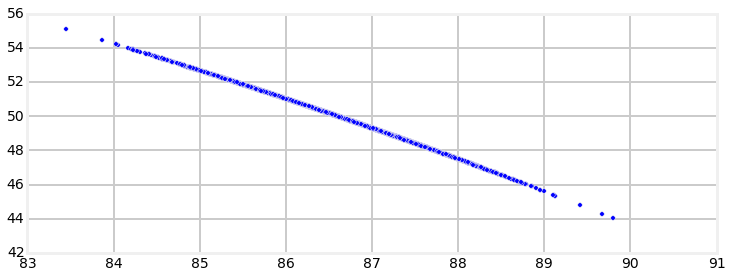

In [34]:
d = 100
xs, ys = [], []

for i in range (3000):
    a = math.radians(30) + randn() * math.radians(1)
    
    xs.append(d*math.cos(a))
    ys.append(d*math.sin(a))
    
plt.scatter(xs, ys)
plt.show() 

## Exercise: Explain Filter Performance

We can see that for even very small angular errors the (x, y) positional errors are very large. Explain how we got such relatively good performance out of the UKF in the target tracking problems above. Answer this for the one sensor problem as well as the multiple sensor problem. 

### Solution

> This is **very** important to understand. Try very hard to answer this before reading the answer below. If you cannot answer this you really need to revisit some of the earlier Kalman filter material in the Multidimensional Kalman filter chapter.

There are several factors contributing to our success. First, let's consider the case of having only one sensor. Any single measurement has an extreme range of possible positions. But, our target is moving, and the UKF is taking that into account. Let's plot the results of several measurements taken in a row for a moving target to form an intuition.

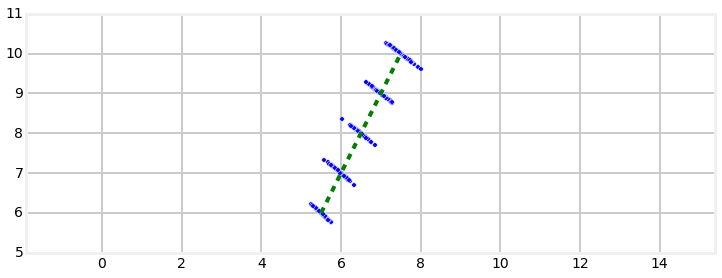

In [35]:
pos = [5, 5]
for i in range(5):
    pos[0] += 0.5
    pos[1] += 1  
    
    actual_angle = math.atan2(pos[1], pos[0])
    d = math.sqrt(pos[0]**2 + pos[1]**2)

    xs, ys = [], []
    for i in range (100):
        a = actual_angle + randn() * math.radians(1)
        xs.append(d*math.cos(a))
        ys.append(d*math.sin(a))
    plt.scatter(xs, ys)

plt.axis('equal')
plt.plot([5.5, pos[0]], [6, pos[1]], c='g', linestyle='--')
plt.show()

We can see that each individual measurement has a very large position error. However, when we plot successive measurements we suddenly have a clear trend - the target is obviously moving towards the upper right. When the Kalman filter (whether a linear KF, an EKF, or UKF) computes the Kalman gain it takes the distribution of errors into account by using the measurement function. In this example the error lies on an approximately $45^\circ$ degree line, so the filter will discount errors in that direction. On the other hand, there is almost no error in measurement orthogonal to that, and again the Kalman gain will be taking that into account. The end result is the track can be computed even with this sort of noise distribution. Of course, this graph makes it look easy because we have computed 100 possible measurements for each position update and plotted them all. This makes it easy for us to see where the target is moving. In contrast, the Kalman filter only gets 1 measurement per update. Therefore the filter will not be able to generate as good a fit as the dotted green line implies. 

The next interaction we must think about is the fact that the bearing gives us no distance information. Suppose in the example above we told the filter that the initial position of the target was 1000km away from the sensor (vs the actual distance of 7.07 km), and that we were highly confident in that guess by setting $\mathbf{P}$ very small. At that distance a $1^\circ$ error translates into a positional error of 17.5 km. The KF would never be able to converge onto the actual target position because the filter is incorrectly very certain about its position estimates and because there is no distance information provided in the measurements.

Now let's consider the effect of adding a second sensor. Again, I will start by plotting the measurements so we can form an intuition about the problem.

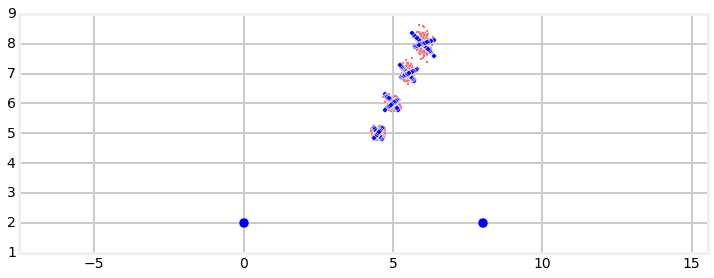

In [36]:
from math import sin, cos, atan2, pi

def isct(pa, pb, alpha, beta):
    """ Returns the (x, y) intersections of points pa and pb
    given the bearing ba for point pa and bearing bb for
    point pb.
    """
    
    B = [pb[0] - pa[0], pb[1] - pa[1]]

    AB = math.sqrt((pa[0] - pb[0])**2 + (pa[1] - pb[1])**2) 
    
    ab = atan2(B[1], B[0])
    a = alpha - ab    
    b = pi - beta - ab
    p = pi - b - a
    
    AP = (sin(b) / sin(p)) * AB
    
    x = cos(alpha) * AP + pa[0]
    y = sin(alpha) * AP + pa[1]
    return x, y


def plot_iscts(N=4):
    for i in range(N):
        pos[0] += 0.5
        pos[1] += 1  

        actual_angle_a = math.atan2(pos[1] - sa[1], pos[0] - sa[0])
        actual_angle_b = math.atan2(pos[1] - sb[1], pos[0] - sb[0])

        da = math.sqrt((sa[0] - pos[0])**2 + (sa[1] - pos[1])**2)
        db = math.sqrt((sb[0] - pos[0])**2 + (sb[1] - pos[1])**2)

        xs, ys, xs_a, xs_b, ys_a, ys_b = [], [], [], [], [], []

        for i in range (300):
            a_a = actual_angle_a + randn() * math.radians(1)
            a_b = actual_angle_b + randn() * math.radians(1)

            x,y = isct(sa, sb, a_a, a_b)
            xs.append(x)
            ys.append(y)

            xs_a.append(da*math.cos(a_a) + sa[0])
            ys_a.append(da*math.sin(a_a) + sa[1])

            xs_b.append(db*math.cos(a_b) + sb[0])
            ys_b.append(db*math.sin(a_b) + sb[1])

        plt.scatter(xs, ys, c='r', marker='.')
        plt.scatter(xs_a, ys_a)
        plt.scatter(xs_b, ys_b)

    plt.axis('equal')
    plt.show()

pos = [4, 4]
sa = [0, 2]
sb = [8, 2]

plt.scatter(*sa, s=100)
plt.scatter(*sb, s=100)
plot_iscts(N=4)

I placed the sensors nearly orthogonal to the target's initial position so we get these lovely 'x' shape intersections. I then computed the (x, y) coordinate corresponding to the two noisy bearing measurements and plotted them with red dots to show the distribution of the noisy measurements in x and y. We can see how the errors in x and y change as the target moves by the shape the scattered red dots make - as the target gets further away from the sensors, but nearer the y coordinate of sensor B the shape becomes strongly elliptical.

Next I will alter the starting positions and rerun the simulation. Here the shape of the errors in x and y changes radically as the target position changes relative to the two sensors. 

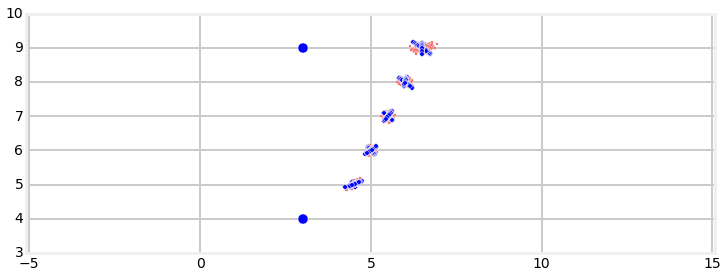

In [37]:
sa = [3, 4]
sb = [3, 9]
pos= [4, 4]

plt.scatter(*sa, s=100)
plt.scatter(*sb, s=100)
plot_iscts(N=5)

## Implementation of the UKF

Now let's implement these equations with Python. As you have seen FilterPy already implements this code for you, but it is instructive to learn how to go from equations to code. Plus, if you encounter a problem and need to debug your code you will likely need to step through the code with the debugger.

Implementing the UKF is quite straightforward. First, let's write the code to compute the mean and covariance given the sigma points. 

We will store the sigma points and weights in matrices, like so:

$$ 
\begin{aligned}
weights &= 
\begin{bmatrix}
w_1&w_2& \dots & w_{2n+1}
\end{bmatrix} 
\\
sigmas &= 
\begin{bmatrix}
\mathcal{X}_{0,0} & \mathcal{X}_{0,1} &  \mathcal{X}_{0,2} \\
\mathcal{X}_{1,0} & \mathcal{X}_{1,1} &  \mathcal{X}_{1,2} \\
\vdots & \vdots & \vdots \\
\mathcal{X}_{2n+1,0} & \mathcal{X}_{2n+1,1} & \mathcal{X}_{2n+1,2}
\end{bmatrix}
\end{aligned}
$$

In other words, each column contains the $2n+1$ sigma points for one dimension in our problem. The $0th$ sigma point is always the mean, so first row of sigma's contains the mean of each of our dimensions. The second through nth row contains the $\mu+\sqrt{(n+\lambda)\Sigma}$ terms, and the $n+1$ to $2n$ rows contains the $\mu-\sqrt{(n+\lambda)\Sigma}$ terms. the choice to store the sigmas in row-column vs column row format is somewhat arbitrary; my choice makes the rest of the code a bit easier to code as I can refer to the ith sigma point for all dimensions as `sigmas[i]`.

### Weights

Computing the weights in numpy is extremely simple. Recall that for the Van der Merwe scaled sigma point implementation

$$
\begin{aligned}
W^m_0 &= \frac{\lambda}{n+\lambda} \\
W^c_0 &= \frac{\lambda}{n+\lambda} + 1 -\alpha^2 + \beta \\
W^m_i = W^c_i &= \frac{1}{2(n+\lambda)}\;\;\;i=1..2n
\end{aligned}
$$

with $\lambda=\alpha^2(n+\kappa)-n$.
    
Our code will look something like this.

    lambda_ = alpha**2 * (n +kappa) - n
    Wc = np.full(2*n + 1,  1. / (2*(n+lambda_))
    Wm = np.full(2*n + 1,  1. / (2*(n+lambda_))
    Wc[0] = lambda_ / (n + lambda_) + (1. - alpha**2 + beta)
    Wm[0] = lambda_ / (n + lambda_)

### Sigma Points

###### The equations for the sigma points are:

$$
\begin{aligned}
\mathcal{X}_0 &= \mu \\
\mathcal{X}_i &= \mu +  \bigg[\sqrt{(n+\lambda)\Sigma}  \bigg]_i\,\,\,\, &\text{for}\text{ i=1 .. n} \\
\mathcal{X}_i &= \mu - \bigg[\sqrt{(n+\lambda)\Sigma}\bigg]_{i-n}\,\,\,\,\, &\text{for}\text{ i=(n+1) .. 2n}
\end{aligned}
$$

The Python for this is not much more difficult once we wrap our heads around the $[\sqrt{(n+\kappa)\Sigma}]_i$ term.

The term $[\sqrt{(n+\kappa)\Sigma}]_i$ has to be a matrix because $\Sigma$ is a matrix. The subscript $i$ is choosing the column vector of the matrix. What is the square root of a matrix? There is no unique definition. A typical definition is that the square root of a matrix $\Sigma$ is just the matrix $S$ that, when multiplied by itself, yields $\Sigma$.

$$
\begin{aligned}
\text{if }\Sigma = SS \\
\\
\text{then }S = \sqrt{\Sigma}
\end{aligned}
$$

However there is an alternative definition, and we will chose it because it has numerical properties that makes it much easier for us to compute its value. We can define the square root as the matrix S, which when multiplied by its transpose, returns $\Sigma$:

$$
\Sigma = SS^\mathsf{T} \\
$$

This method is frequently chosen in computational linear algebra because this expression is easy to compute using something called the *Cholesky decomposition* [3]. 
SciPy provides this with the `scipy.linalg.cholesky()` method. If your language of choice is Fortran, C, or C++, libraries such as LAPACK provide this routine. Matlab provides `chol()`.

    sigmas = np.zeros((2*n+1, n))
    U = scipylinalg.cholesky((n+kappa)*P)

    sigmas[0] = X
    for k in range (n):
        sigmas[k+1]   = X + U[k]
        sigmas[n+k+1] = X - U[k]

Now let's implement the unscented transform. Recall the equations

$$\begin{aligned}
\mu &= \sum_i w_i^m\mathcal{X}_i \\
\Sigma &= \sum_i w_i^c{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}}
\end{aligned}
$$

We implement the sum of the means with

    X = np.dot (Wm, sigmas)

If you are not a heavy user of NumPy this may look foreign to you. NumPy is not just a library that make linear algebra possible; under the hood it is written in C to achieve much faster speeds than Python can reach. A typical speedup is 100x. To get that speedup we must avoid using for loops, and instead use NumPy's built in functions to perform calculations. So, instead of writing a for loop to compute the sum, we call the built in `numpy.dot(x,y)` method. If passed a 1D array and a 2D array it will compute the sum of inner products:

In [38]:
a = np.array([10, 100])
b = np.array([[1, 2, 3],
              [4, 5, 6]])
np.dot(a,b)

array([410, 520, 630])

All that is left is to compute $\mathbf{P} = \sum_i w_i{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}} + \mathbf{Q}$

    kmax, n = sigmas.shape
    P = zeros((n, n))
    for k in range(kmax):
        y = sigmas[k] - x
        P += Wc[k] * np.outer(y, y) 
    P += Q

This introduces another feature of NumPy. The state variable $X$ is one dimensional, as is $sigmas[k]$, so the difference $sigmas[k]-X$ is also one dimensional. NumPy will not compute the transpose of a 1-D array; it considers the transpose of `[1,2,3]` to be `[1,2,3]`. So we call the function `np.outer(y,y)` which computes the value of $\mathbf{yy}^\mathsf{T}$ for a 1D array $\mathbf{y}$.

### Predict Step

For the predict step, we will generate the weights and sigma points as specified above. We pass each sigma point through the function f.

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi})$$

Then we compute the predicted mean and covariance using the unscented transform. In the code below you can see that I am assuming that this is a method in a class that stores the various matrices and vectors needed by the filter.

    def predict(self):
        """ Performs the predict step of the UKF. On return, self.xp and
        self.Pp contain the predicted state (xp) and covariance (Pp). 'p'
        stands for prediction.
        """

        # calculate sigma points for given mean and covariance
        sigmas = sigma_points(self.x, self.P, self.kappa)

        for i in range(self._num_sigmas):
            self.sigmas_f[i] = self.fx(sigmas[i], self._dt)

        self.xp, self.Pp = unscented_transform(
                           self.sigmas_f, self.W, self.W, self.Q)

### Update Step

The update step converts the sigmas into measurement space via the `h(x)` function.


$$\mathcal{Z} = h(\mathcal{Y})$$

The mean and covariance of those points is computed with the  unscented transform. The residual and Kalman gain is then computed. The cross variance is computed as:

$$\mathbf{P}_{xz} =\sum w^c(\boldsymbol{\chi}-\mu)(\boldsymbol{\mathcal{Z}}-\mathbf{\mu}_z)^\mathsf{T}$$


Finally, we compute the new state estimate using the residual and Kalman gain:


$$K = \mathbf{P}_{xz} \mathbf{P}_z^{-1}\\
\hat{\mathbf{x}} = \mathbf{x}^- + \mathbf{Ky}$$

and the new covariance is computed as:

$$ \mathbf{P} = \mathbf{P}^- - \mathbf{KP}_z\mathbf{K}^\mathsf{T}$$

This function can be implemented as follows, assuming it is a method of a class that stores the necessary matrices and data.

In [39]:
def update(self, z):
    """ Update the UKF with the given measurements. On return,
    self.x and self.P contain the new mean and covariance of the filter.

    **Parameters**

    z : numpy.array of shape (dim_z)
        measurement vector
    """

    # rename for readability
    sigmas_f = self.sigmas_f
    sigmas_h = self.sigmas_h

    # transform sigma points into measurement space
    for i in range(self._num_sigmas):
        sigmas_h[i] = self.hx(sigmas_f[i])

    # mean and covariance of prediction passed through inscented transform
    zp, Pz = unscented_transform(sigmas_h, self.W, self.W, self.R)

    # compute cross variance of the state and the measurements
    Pxz = zeros((self._dim_x, self._dim_z))
    for i in range(self._num_sigmas):
        Pxz += self.W[i] * np.outer(sigmas_f[i] - self.xp,
                                    sigmas_h[i] - zp)

    K = dot(Pxz, inv(Pz)) # Kalman gain

    self.x = self.xp + dot(K, z-zp)
    self.P = self.Pp - dot3(K, Pz, K.T)

## Batch Processing

The Kalman filter is designed as a recursive algorithm - as new measurements come in we immediately create a new estimate. But it is very common to have a set of data that have been already collected which we want to filter. Kalman filters can always be run in a *batch* mode, where all of the measurements are filtered at once. We have implemented this in `UnscentedKalmanFilter.batch_filter()`. Internally, all the function does is loop over the measurements and collect the resulting state and covariance estimates in arrays. It may seem a bit trivial, but you will almost always want to do this if you can for several reasons. First, it will execute a bit quicker than if you implement the loop yourself. Second, the logic in your code will be a bit cleaner, and you will have a reduced chance of bugs. Third, and most importantly, it you batch process your data you can then use an extremely powerful technique to generate far smoother results than you have seen so far. We will present that technique in the next section; here I will show you how to use `UnscentedKalmanFilter.batch_filter()`.

All you have to do is collect your measurements into an array or list. Maybe it is in a CSV file, for example.

    zs = read_altitude_from_csv()

Or maybe you will generate it using a generator:

    zs = [some_func(i) for i in range(1000)]
    
Just do whatever it takes to get your measurements in an array.

Now we will just call the `batch_filter()` method.

    Xs, Ps = ukf.batch_filter(zs)
    
The function takes the list/array of measurements, filters it, and returns an array of state estimates (Xs) and covariance matrices (Ps) for the entire data set. 

Here is a complete example drawing from the radar tracking problem above.

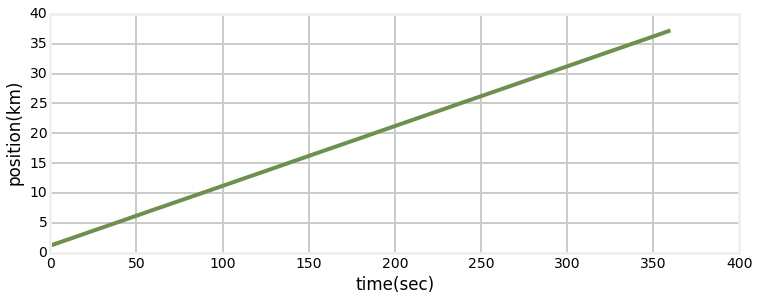

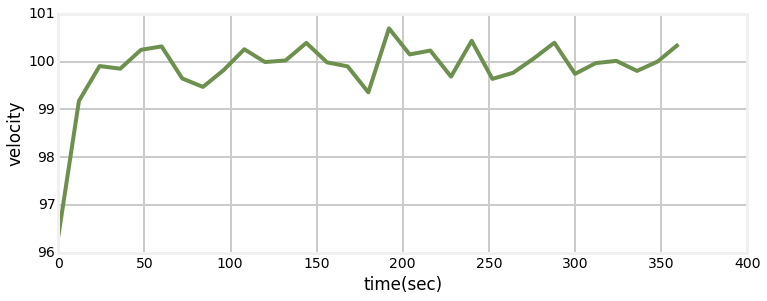

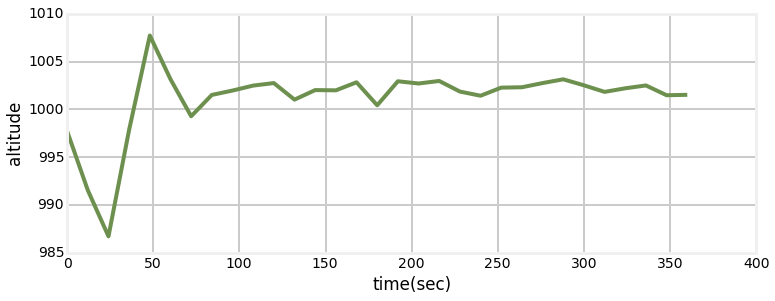

In [40]:
dt = 12. # 12 seconds between readings
range_std = 5 # meters
bearing_std = math.radians(0.5)

ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos

points = MerweScaledSigmaPoints(n=3, alpha=.1, beta=2., kappa=0.)
kf = UKF(3, 2, dt, fx=f_radar, hx=h_radar, points=points)

kf.Q[0:2 ,0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2, 2] = 0.1

kf.R = np.diag([range_std**2, bearing_std**2])
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])

radar = RadarStation(pos=(0, 0), range_std=range_std, bearing_std=bearing_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

random.seed(200)

t = np.arange(0, 360 + dt, dt)
n = len(t)

zs = []
for i in range(len(t)):
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    zs.append([r[0], r[1]])

    
xs, covs = kf.batch_filter(zs)
plot_radar(xs, t)

array([[ 543.42853628,   87.77491996,   -5.26709207],
       [  87.77491996,   14.51416192,    0.01521311],
       [  -5.26709207,    0.01521311,  195.7945557 ]])

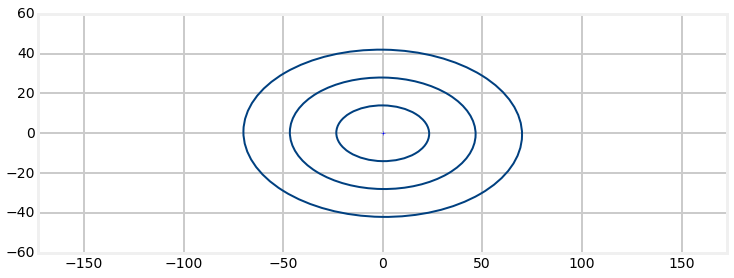

In [41]:
import stats
P = np.array([[kf.P[0,0], kf.P[0, 2]], [kf.P[0,2], kf.P[2,2]]])
stats.plot_covariance_ellipse((0, 0), P, variance=[1, 4, 9])
kf.P

## Smoothing the Results

Briefly, the recursive form of Kalman filtering that we have been using up to now use information from the past to generate the current estimate. Recall the last section, where we used batch processing to filter a collection of measurements. This implies that we know now only the past, but the future! This is a key insight.

Let's assume that  we are tracking a car. Suppose we get a noisy measurement that implies that the car is starting to turn to the left, but the state function has predicted that the car is moving straight. The Kalman filter has no choice but to move the state estimate somewhat towards the noisy measurement, as it cannot judge whether this is just a particularly noisy measurement or the true start of a turn. 

However, if we have measurements from the future we can often figure out if a turn was made or not. Suppose the subsequent measurements all continue turning left. We can then be sure that the measurement was not very noisy, but instead a true indication that a turn was initiated. On the other hand, if the subsequent measurements continued on in a straight line we would know that the measurement was noisy and should be mostly ignored.

We will not develop the math or algorithm here, I will just show you how to call the algorithm in `FilterPy`. The algorithm that we have implemented is called an *RTS smoother*, after the three inventors of the algorithm: Rauch, Tung, and Striebel.

The routine is `UnscentedKalmanFilter.rts_smoother()`. Using it is trivial; we pass in the means and covariances computed from the `batch_filter` step, and receive back the smoothed means, covariances, and Kalman gain.

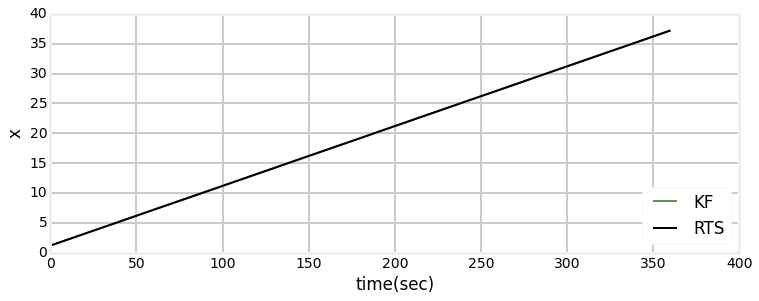

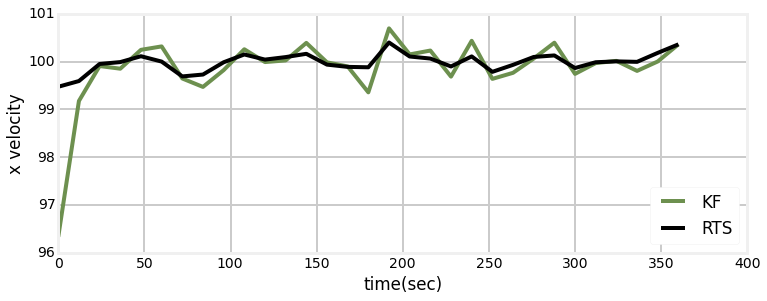

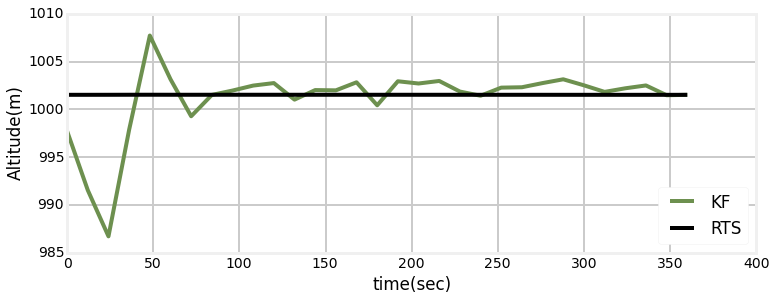

Difference in position in meters: [-0.7717 -0.1195  0.0426 -1.1727 -1.0871]


In [42]:
Ms, P, K = kf.rts_smoother(xs, covs)

plt.figure()
plt.plot(t, xs[:, 0]/1000., label='KF', lw=2)
plt.plot(t, Ms[:, 0]/1000., c='k', label='RTS', lw=2)
plt.xlabel('time(sec)')
plt.ylabel('x')
plt.legend(loc=4)

plt.figure()

plt.plot(t, xs[:, 1], label='KF')
plt.plot(t, Ms[:, 1], c='k', label='RTS')
plt.xlabel('time(sec)')
plt.ylabel('x velocity')
plt.legend(loc=4)

plt.figure()
plt.plot(t, xs[:, 2], label='KF')
plt.plot(t, Ms[:, 2], c='k', label='RTS')
plt.xlabel('time(sec)')
plt.ylabel('Altitude(m)')
plt.legend(loc=4)

plt.show()
np.set_printoptions(precision=4)
print('Difference in position in meters:', xs[-6:-1, 0] - Ms[-6:-1, 0])

From these charts we can see that the improvement in the position is small, but the improvement in the velocity is good, and spectacular for the altitude. The difference in the position are very small, so I printed the difference between the UKF and the smoothed results for the last 5 points.

## Choosing the Sigma Parameters

** author's note: this entire section needs a lot of work. Ignore for now.**

I have found the literature on choosing values for $\alpha$, $\beta$, and $\kappa$ to be rather lacking. Van der Merwe's dissertation contains the most information, but it is not exhaustive. So let's just explore what they do. 

Van der Merwe suggests using $\beta=2$ for Gaussian problems, and $\kappa=3-n$. So let's start there and vary $\alpha$. I will let $n=1$ minimize the size of the arrays we need to look at and to avoid having to compute the square root of matrices

In [43]:
def print_sigmas(n=1, mean=5, cov=3, alpha=.1, beta=2., kappa=2):
    points = MerweScaledSigmaPoints(n, alpha, beta, kappa)
    print('sigmas: ', points.sigma_points(mean,  cov).T[0])
    Wm, Wc = points.weights()
    print('mean weights:', Wm)
    print('cov weights:', Wc)
    print('lambda:', alpha**2 *(n+kappa) - n)
    print('sum cov', sum(Wc))
    
print_sigmas(mean=0, cov=3, alpha=1)

sigmas:  [ 0.  3. -3.]
mean weights: [ 0.6667  0.1667  0.1667]
cov weights: [ 2.6667  0.1667  0.1667]
lambda: 2
sum cov 3.0


So what is going on here? We can see that for a mean of 0 the algorithm choose sigma points of 0, 3, and -3, but why? Recall the equation for computing the sigma points:

$$\begin{aligned}
\mathcal{X}_0 &= \mu\\
\mathcal{X}_i &= \mu \pm \sqrt{(n+\lambda)\Sigma}
\end{aligned}$$

Here you will appreciate my choice of $n=1$ as it reduces everything to scalars, allowing us to avoid computing the square root of matrices. So, for our values the equation is

$$\begin{aligned}
\mathcal{X}_0 &= 0 \\
\mathcal{X}_i &= 0 \pm \sqrt{(1+2)\times 3} \\
&= 0 \pm \sqrt{9} \\
&= \pm 3
\end{aligned}$$

So as $\alpha$ gets larger the sigma points get more spread out. Let's set it to an absurd value.

In [44]:
print_sigmas(mean=0, cov=3, alpha=200)

sigmas:  [   0.  600. -600.]
mean weights: [ 1.  0.  0.]
cov weights: [-39996.      0.      0.]
lambda: 119999
sum cov -39996.0


We can see that the sigma point spread over 100 standard deviations.If our data was Gaussian we'd be incorporating data many standard deviations away from the mean; for nonlinear problems this is unlikely to produce good results. But suppose our distribution was not Gaussian, but instead had very fat tails? We might need to sample from those tails to get a good estimate, and hence it would make sense to make $kappa$ larger (not 200, which was absurdly large just to make the change in the sigma points stark). 

With a similar line of reasoning, suppose that our distribution has nearly no tails - the probability distribution looks more like an inverted parabola. In such a case we'd probably want to pull the sigma points in closer to the mean to avoid sampling in regions where there will never be real data.

Now let's look at the change in the weights. When we have $k+n=3$ the weights were 0.6667 for the mean, and 0.1667 for the two outlying sigma points. On the other hand, when $\alpha=200$ the mean weight shot up to 0.99999 and the outlier weights were set to 0.000004. Recall the equations for the weights:

$$\begin{aligned}
W_0 &= \frac{\lambda}{n+\lambda} \\
W_i &= \frac{1}{2(n+\lambda)}
\end{aligned}$$

We can see that as $\lambda$ gets larger the fraction for the weight of the mean ($\lambda/(n+\lambda)$) approaches 1, and the fraction for the weights of the rest of the sigma points approaches 0. This is invariant on the size of your covariance. So as we sample further and further away from the mean we end up giving less weight to those samples, and if we sampled very close to the mean we'd give very similar weights to all.

However, the advice that Van der Merwe gives is to constrain $\alpha$ in the range $0 \gt \alpha \ge 1$. He suggests $10^{-3}$ as a good value. Lets try that.

In [45]:
print_sigmas(mean=0, cov=13, alpha=.1, kappa=0)

sigmas:  [ 0.      0.3606 -0.3606]
mean weights: [-99.  50.  50.]
cov weights: [-96.01  50.    50.  ]
lambda: -0.99
sum cov 3.99


I must admit to not fully understanding this advice. 

In [46]:
print_sigmas(mean=0, cov=3, alpha=.1)

sigmas:  [ 0.   0.3 -0.3]
mean weights: [-32.3333  16.6667  16.6667]
cov weights: [-29.3433  16.6667  16.6667]
lambda: -0.97
sum cov 3.99


In [47]:
print_sigmas(mean=0, cov=3, alpha=1)

sigmas:  [ 0.  3. -3.]
mean weights: [ 0.6667  0.1667  0.1667]
cov weights: [ 2.6667  0.1667  0.1667]
lambda: 2
sum cov 3.0


In [48]:
print_sigmas(mean=0, cov=3, alpha=.1, beta=2, kappa=1)

sigmas:  [ 0.      0.2449 -0.2449]
mean weights: [-49.  25.  25.]
cov weights: [-46.01  25.    25.  ]
lambda: -0.98
sum cov 3.99


## Robot Localization - A Fully Worked Example

It is time to try a real problem. I warn you that this is far from a simple problem. However, most books choose simple, textbook problems with simple answers, and you are left wondering how to implement a real world solution. 

We will consider the problem of robot localization. In this scenario we have a robot that is moving through a landscape with sensors that give range and bearings to various landmarks. This could be a self driving car using computer vision to identify trees, buildings, and other landmarks. Or, it might be one of those small robots that  vacuum your house. It could be a search and rescue device meant to go into dangerous areas to search for survivors. It doesn't matter too much. 

Our robot is wheeled, which means that it manuevers by turning it's wheels. When it does so, the robot pivots around the rear axle while moving forward. This is nonlinear behavior which we will have to account for. The robot has a sensor that gives it approximate range and bearing to known targets in the landscape. This is nonlinear because computing a position from  a range and bearing requires square roots and trigonometry. 

### Robot Motion Model

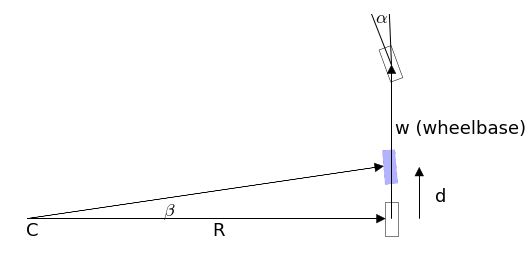

In [49]:
ekf_internal.plot_bicycle()

At a first approximation n automobile steers by turning the front tires while moving forward. The front of the car moves in the direction that the wheels are pointing while pivoting around the rear tires. This simple description is complicated by issues such as slippage due to friction, the differing behavior of the rubber tires at different speeds, and the need for the outside tire to travel a different radius than the inner tire. Accurately modelling steering requires an ugly set of differential equations. For Kalman filtering, especially for lower speed robotic applications a simpler *bicycle model* has been found to perform well. 

I have depicted this model above. Here we see the front tire is pointing in direction $\alpha$. Over a short time period the car moves forward and the rear wheel ends up further ahead and slightly turned inward, as depicted with the blue shaded tire. Over such a short time frame we can approximate this as a turn around a radius $R$. If you google bicycle model you will find that we can compute the turn angle $\beta$ with

$$\beta = \frac{d}{w} \tan{(\alpha)}$$

and the turning radius R is given by 

$$R = \frac{d}{\beta}$$

where the distance the rear wheel travels given a forward velocity $v$ is $d=v\Delta t$.

If we let $\theta$ be our current orientation then we can compute the position $C$ before the turn starts as

$$ C_x = x - R\sin(\theta) \\
C_y = y + R\cos(\theta)
$$

After the move forward for time $\Delta t$ the new position and orientation of the robot is

$$\begin{aligned} x &= C_x + R\sin(\theta + \beta) \\
y &= C_y - R\cos(\theta + \beta) \\
\theta &= \theta + \beta
\end{aligned}
$$

Once we substitute in for $C$ we get

$$\begin{aligned} x &= x - R\sin(\theta) + R\sin(\theta + \beta) \\
y &= y + R\cos(\theta) - R\cos(\theta + \beta) \\
\theta &= \theta + \beta
\end{aligned}
$$

You don't really need to understand this math in detail, as it is already a simplification of the real motion. The important thing to recognize is that our motion model is nonlinear, and we will need to deal with that with our Kalman filter.

### Design the State Variables

For our robot we will maintain the position and orientation of the robot:

$$\mathbf{x} = \begin{bmatrix}x & y & \theta\end{bmatrix}^\mathsf{T}$$

I could include velocities into this model, but as you will see the math will already be quite challenging.

Our control input $\mathbf{u}$ is the velocity and steering angle

$$\mathbf{u} = \begin{bmatrix}v & \alpha\end{bmatrix}^\mathsf{T}$$

### Design the System Model

In general we model our system as a nonlinear motion model plus noise.

$$x^- = x + f(x, u) + \mathcal{N}(0, Q)$$

Using the motion model for a robot that we created above, we can write:

In [50]:
from math import tan, sin, cos, sqrt

def move(x, u, dt, wheelbase):
    h = x[2]
    v = u[0]
    dist = v*dt
    steering_angle = u[1]
    if abs(steering_angle) < 0.0001:
        # approximate straight line with huge radius
        r = 1.e30
        steering_angle = 1e-5
        
    b = dist / wheelbase * tan(steering_angle)
    r = wheelbase / tan(steering_angle) # radius

    sinh = sin(h)
    sinhb = sin(h + b)
    cosh = cos(h)
    coshb = cos(h + b)

    return x + np.array([-r*sinh + r*sinhb, r*cosh - r*coshb, b])

Now we can use this function to implement the function `f(x)` which implements the system model.

In [51]:
def fx(x, dt, u):
    return move(x, u, dt, wheelbase)

### Design the Measurement Model

Now we need to design our measurement model. For this problem we are assuming that we have a sensor that receives a noisy bearing and range to multiple known locations in the landscape. The measurement model must convert the state $\begin{bmatrix}x & y&\theta\end{bmatrix}^\mathsf{T}$ into a range and bearing to the landmark. Using $p$ be the position of a landmark, the range $r$ is

$$r = \sqrt{(p_x - x)^2 + (p_y - y)^2}$$

We assume that the sensor provides bearing relative to the orientation of the robot, so we must subtract the robot's orientation from the bearing to get the sensor reading, like so:

$$\phi = \arctan(\frac{p_y - y}{p_x - x}) - \theta$$


Thus our function is


$$\begin{aligned}
\mathbf{x}& = h(x,p) &+ \mathcal{N}(0, R)\\
&= \begin{bmatrix}
\sqrt{(p_x - x)^2 + (p_y - y)^2} \\
\arctan(\frac{p_y - y}{p_x - x}) - \theta 
\end{bmatrix} &+ \mathcal{N}(0, R)
\end{aligned}$$

This is clearly nonlinear but it poses no particular difficulty to us as we just need to compute this with a python function `h(x)`:

In [52]:
from math import atan2

def Hx(x, landmark):
    """ takes a state variable and returns the measurement that would
    correspond to that state.
    """
    px = landmark[0]
    py = landmark[1]
    dist = np.sqrt((px - x[0])**2 + (py - x[1])**2)

    Hx = np.array([dist, atan2(py - x[1], px - x[0]) - x[2]])
    return Hx

### Design Measurement Noise

This is quite straightforward as we need to specify measurement noise in measurement space, hence it is linear. It is reasonable to assume that the range and bearing measurement noise is independent, hence

$$R=\begin{bmatrix}\sigma_{range}^2 & 0 \\ 0 & \sigma_{bearing}^2\end{bmatrix}$$

### Implementation

Before we begin coding the main loop we have another issue to handle. The residual is notionally computed as $y = z - h(x)$ but this will not work because our measurement contains an angle in it. Suppose z has a bearing of $1^\circ$ and $h(x)$ has a bearing of $359^\circ$. Naively subtracting them would yield a bearing difference of $-358^\circ$. this will throw off the computation of the Kalman gain because the correct angle difference in this case is $-2^\circ$. So we will have to write code to correctly compute the bearing residual.

In [53]:
def normalize_angle(x):
    if x > np.pi:
        x -= 2*np.pi
    if x < -np.pi:
        x = 2*np.pi
    return x

The state vector has the bearing at position 2, but the measurement vector has it at position 1, so we need to write functions to handle each. These will be passed into the `UnscentedKalmanFilter.__init__()` function.

In [54]:
def residual_h(a, b):
    y = a - b
    y[1] = normalize_angle(y[1])
    return y


def residual_x(a, b):
    y = a - b
    y[2] = normalize_angle(y[2])
    return y

Our difficulties are not over. The unscented transform computes the average of the state and measurement vectors, but each contains a bearing. There is no unique way to compute the average of a set of angles. For example, what is the average of 359$^\circ$ and 3$^\circ$? Intuition suggests the answer should be 1$^\circ$, but a naive sum/count approach yields 181$^\circ$.

One common approach is to take the arctan of the sum of the sins and cosines.

$$\bar{\theta} = atan2\left(\frac{\sum_{i=1}^n \sin\theta_i}{n}, \frac{\sum_{i=1}^n \cos\theta_i}{n}\right)$$

We have not used this feature yet, but the `UnscentedKalmanFilter.__init__()` method has an argument `x_mean_fn` that allows you to provide a function which compute the mean for the state, and `z_mean_fn` for a function which computes the mean of the measurement. We will code these function as:

In [55]:
def state_mean(sigmas, Wm):
    x = np.zeros(3)
    sum_sin, sum_cos = 0., 0.

    for i in range(len(sigmas)):
        s = sigmas[i]
        x[0] += s[0] * Wm[i]
        x[1] += s[1] * Wm[i]
        sum_sin += sin(s[2])*Wm[i]
        sum_cos += cos(s[2])*Wm[i]

    x[2] = atan2(sum_sin, sum_cos)
    return x


def z_mean(sigmas, Wm):
    x = np.zeros(2)
    sum_sin, sum_cos = 0., 0.

    for i in range(len(sigmas)):
        s = sigmas[i]
        x[0] += s[0] * Wm[i]
        sum_sin += sin(s[1])*Wm[i]
        sum_cos += cos(s[1])*Wm[i]

    x[1] = atan2(sum_sin, sum_cos)
    return x

With that done we are now ready to implement the UKF. You've seen this sort of code many times, so I will not describe it in detail. There are two new things here, one trivial, one important. 

First the trivial point. When we construct the filter we have to provide it the functions that we have written to compute the residuals and means.

    ukf = UKF(dim_x=3, dim_z=2, fx=fx, hx=Hx, dt=dt, points=points,
             x_mean_fn=state_mean, z_mean_fn=z_mean,
             residual_x=residual_x, residual_z=residual_h)

The far more important point is how we update the filter with our measurements. As the robot moves around in its environment various landmarks will come into and go out of range. How should we incorpate a varying number of measurements? It turns out to be very very simple. We will just call `update()` once for each landmark that we sense. In other words, if the robot sees 3 landmarks then one call to `predict()` will be followed by 3 calls to `update()`. If this seems unlikely to work, just think of it as receiving 3 separate measurements with no time between them. If no time passed the robot could not have moved, and thus no change in position or uncertainty happened, and thus there is no need to call `predict()`. This is a very common method in Kalman filtering.

The rest of the code runs the simulation and plots the results, and shouldn't need too much comment by now. I create a variable `landmarks` that contains the coordinates of the landmarks. I update the simulated robot position 10 times a second, but run the EKF only once. This is for two reasons. First, we are not using Runge Kutta to integrate the differental equations of motion, so a narrow time step allows our simulation to be more accurate. Second, it is fairly normal in embedded systems to have limited processing speed. This forces you to run your Kalman filter only as frequently as absolutely needed.

In [56]:
from filterpy.common import plot_covariance_ellipse

dt = 1.0
wheelbase = 0.5

def run_localization(cmds, landmarks, sigma_vel, sigma_steer, sigma_range, 
                     sigma_bearing, ellipse_step=1, step=10):
    
    
    points = MerweScaledSigmaPoints(n=3, alpha=.00001, beta=2, kappa=0)
    ukf = UKF(dim_x=3, dim_z=2, fx=fx, hx=Hx, dt=dt, points=points,
             x_mean_fn=state_mean, z_mean_fn=z_mean,
             residual_x=residual_x, residual_z=residual_h)
    ukf.x = np.array([2, 6, .3])
    ukf.P = np.diag([.1, .1, .1])
    ukf.R = np.diag([sigma_range**2, sigma_bearing**2])
    ukf.Q = np.zeros((3,3))
    ukf.Q = np.eye(3)*0.0001
    
    u = np.array([1.1, .01])
    sim_pos = ukf.x.copy()
    
    # plot landmarks
    plt.scatter(landmarks[:, 0], landmarks[:, 1], marker='s', s=60)
    
    track = []
    for i, u in enumerate(cmds):
        
        sim_pos = move(sim_pos, u, dt/step, wheelbase) # simulate robot
        track.append(sim_pos)

        if i % step == 0:
            ukf.predict(fx_args=u)

            if i % ellipse_step == 0:
                plot_covariance_ellipse((ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=6,
                                        facecolor='b', alpha=0.08)

            x, y = sim_pos[0], sim_pos[1]
            for lmark in landmarks:
                d = sqrt((lmark[0] - x)**2 + (lmark[1] - y)**2)
                a = atan2(lmark[1] - y, lmark[0] - x) - sim_pos[2]
                z = np.array([d + randn()*sigma_range, a + randn()*sigma_bearing])

                ukf.update(z, hx_args=(lmark,))

            if i % ellipse_step == 0:
                plot_covariance_ellipse((ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=6,
                                        facecolor='g', alpha=0.4)
    track = np.array(track)
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)
    plt.axis('equal')
    plt.title("UKF Robot localization")
    plt.show()
    return ukf

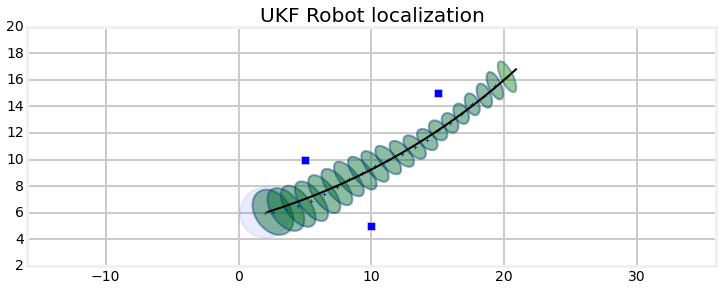

[ 0.0135  0.0376  0.0013]


In [57]:
landmarks = np.array([[5, 10], [10, 5], [15, 15]])
cmds = [np.array([1.1, .01])]*200
ukf = run_localization(cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
                      sigma_range=0.3, sigma_bearing=0.1)
print(ukf.P.diagonal())

The rest of the code runs the simulation and plots the results, and shouldn't need too much comment by now. I create a variable `landmarks` that contains the coordinates of the landmarks. I update the simulated robot position 10 times a second, but run the EKF only once. This is for two reasons. First, we are not using Runge Kutta to integrate the differental equations of motion, so a narrow time step allows our simulation to be more accurate. Second, it is fairly normal in embedded systems to have limited processing speed. This forces you to run your Kalman filter only as frequently as absolutely needed.

### Steering the Robot

While the robot was turning in the example above, we really can't say it was being driven realistically. The velocity and steering angles never changed, which doesn't pose much of a problem for the Kalman filter. We could implement a complicated PID controlled robot simulation, but I will just generate varying steering commands using NumPy's `linspace` method. I'll also add more landmarks as the robot will be travelling much further than in the first example.

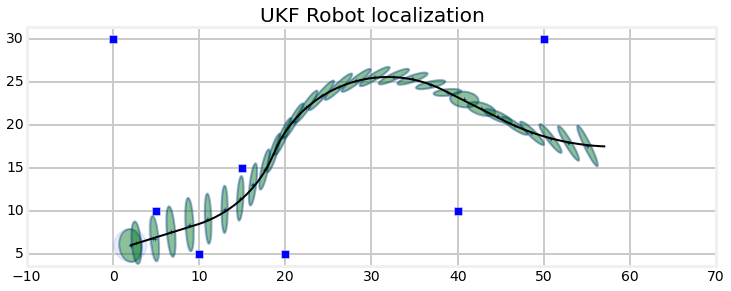

In [58]:
landmarks = np.array([[5, 10], [10, 5], [15, 15], [20, 5],
                      [0, 30], [50, 30], [40, 10]])


dt = 0.1
wheelbase = 0.5
sigma_range=0.3
sigma_bearing=0.1

# accelerate from a stop
cmds = [[v, .0] for v in np.linspace(0.001, 1.1, 30)]
cmds.extend([cmds[-1]]*50)

# turn left
v = cmds[-1][0]
cmds.extend([[v, a] for a in np.linspace(0, np.radians(2), 15)])
cmds.extend([cmds[-1]]*100)

#turn right
cmds.extend([[v, a] for a in np.linspace(np.radians(2), -np.radians(2), 15)])
cmds.extend([cmds[-1]]*200)

cmds.extend([[v, a] for a in np.linspace(-np.radians(2), 0, 15)])
cmds.extend([cmds[-1]]*50)

cmds.extend([[v, a] for a in np.linspace(0, np.radians(1), 25)])
cmds.extend([cmds[-1]]*100)

ukf = run_localization(cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
                      sigma_range=0.3, sigma_bearing=0.1, step=1,
                      ellipse_step=20)


## References

- [1] Rudolph Van der Merwe. "Sigma-Point Kalman Filters for Probabilistic Inference in Dynamic State-Space Models" dissertation (2004).

- [2] Simon J. Julier. "The Scaled Unscented Transformation". Proceedings of the American Control Conference 6. IEEE. (2002)

- [1] http://www.esdradar.com/brochures/Compact%20Tracking%2037250X.pdf

- [2] Julier, Simon J.; Uhlmann, Jeffrey "A New Extension of the Kalman  Filter to Nonlinear Systems". Proc. SPIE 3068, Signal Processing, Sensor Fusion, and Target Recognition VI, 182 (July 28, 1997)

- [3] Cholesky decomposition. Wikipedia. http://en.wikipedia.org/wiki/Cholesky_decomposition